# Bank Marketing Campaign - Binary Classification Project

## Project Overview
This project analyzes a Portuguese banking institution's direct marketing campaigns (phone calls) to predict whether a client will subscribe to a term deposit.

**Dataset**: `bank-additional-full.csv`  from Kaggle  (link: https://www.kaggle.com/datasets/sahistapatel96/bankadditionalfullcsv)  
**Target Variable**: y (yes/no - will client subscribe to term deposit)

## Imports and Setup

In [1]:
# pip install hyperopt
# pip install xgboost

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

import shap
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from xgboost import XGBClassifier
import xgboost as xgb
import joblib

np.random.seed(42)
pd.set_option('display.max_columns', None)

## 1. Data Loading and Initial Exploration

In [3]:
df = pd.read_csv('bank-additional-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
print(f"Dataset shape: {df.shape}")
print("="*50)

print("\nDataset info:")
print(df.info())
print("="*50)

print("\nMissing values:")
print(df.isnull().sum())
print("="*50)

print("\nTarget variable distribution:")
print(df['y'].value_counts())
print(f"Target balance: {df['y'].value_counts(normalize=True)}")

Dataset shape: (41188, 21)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  fl

## 2. Exploratory Data Analysis (EDA)

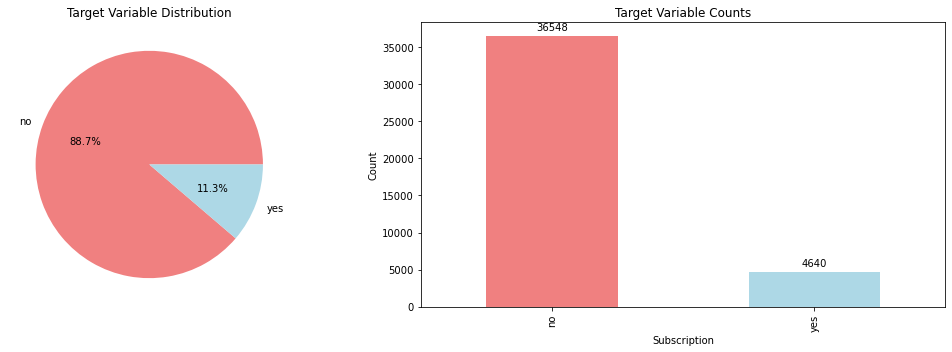

Class Imbalance Ratio: 7.9:1


In [5]:
# 1. Target Variable Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Target distribution
target_counts = df['y'].value_counts()
axes[0].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
           colors=['lightcoral', 'lightblue'])
axes[0].set_title('Target Variable Distribution')

# Target distribution with counts
target_counts.plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightblue'])
axes[1].set_title('Target Variable Counts')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Subscription')
for i, v in enumerate(target_counts.values):
    axes[1].text(i, v + 500, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Class Imbalance Ratio: {target_counts['no'] / target_counts['yes']:.1f}:1")

Severe imbalance (≈ 89% “no”, 11% “yes”).  
Conclusion: Requires oversampling and careful metric choice (F1, ROC-AUC).

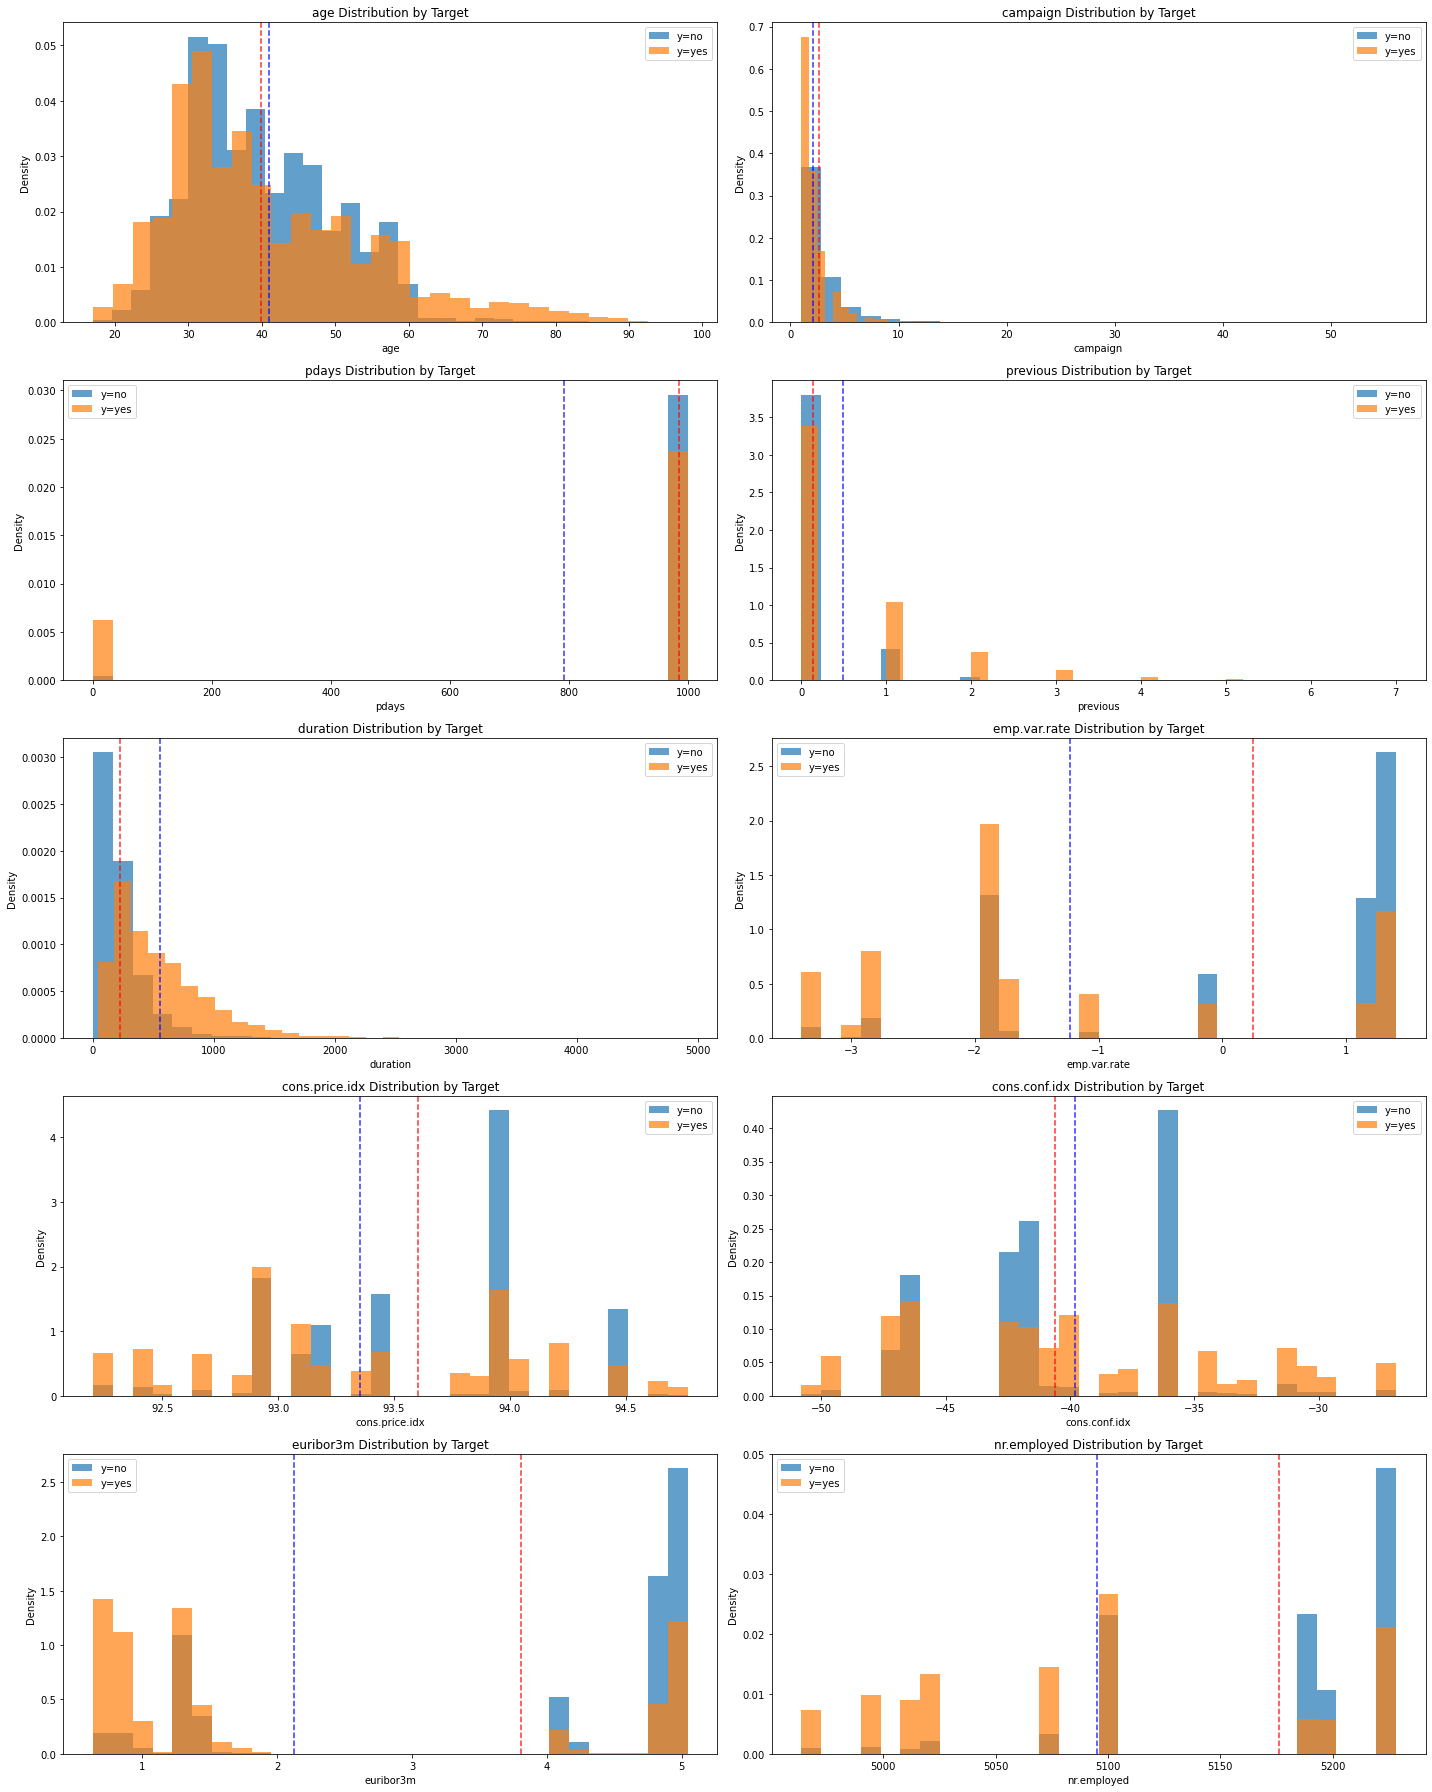


Numerical Features Statistical Summary:
               age      campaign         pdays      previous      duration  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406      2.567593    962.475454      0.172963    258.285010   
std       10.42125      2.770014    186.910907      0.494901    259.279249   
min       17.00000      1.000000      0.000000      0.000000      0.000000   
25%       32.00000      1.000000    999.000000      0.000000    102.000000   
50%       38.00000      2.000000    999.000000      0.000000    180.000000   
75%       47.00000      3.000000    999.000000      0.000000    319.000000   
max       98.00000     56.000000    999.000000      7.000000   4918.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.

In [6]:
# 2. Numerical Features Analysis
numerical_features = ['age', 'campaign', 'pdays', 'previous', 'duration',
                     'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Create comprehensive histograms for numerical features
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.ravel()

for i, feature in enumerate(numerical_features):
    # Histogram with distribution by target
    for target_val in ['no', 'yes']:
        data = df[df['y'] == target_val][feature]
        axes[i].hist(data, bins=30, alpha=0.7, label=f'y={target_val}', density=True)
    
    axes[i].set_title(f'{feature} Distribution by Target')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    
    # Add statistics
    mean_no = df[df['y'] == 'no'][feature].mean()
    mean_yes = df[df['y'] == 'yes'][feature].mean()
    axes[i].axvline(mean_no, color='red', linestyle='--', alpha=0.8, label=f'Mean No: {mean_no:.2f}')
    axes[i].axvline(mean_yes, color='blue', linestyle='--', alpha=0.8, label=f'Mean Yes: {mean_yes:.2f}')

plt.tight_layout()
plt.show()

# Statistical summary for numerical features
print("\nNumerical Features Statistical Summary:")
print(df[numerical_features].describe())

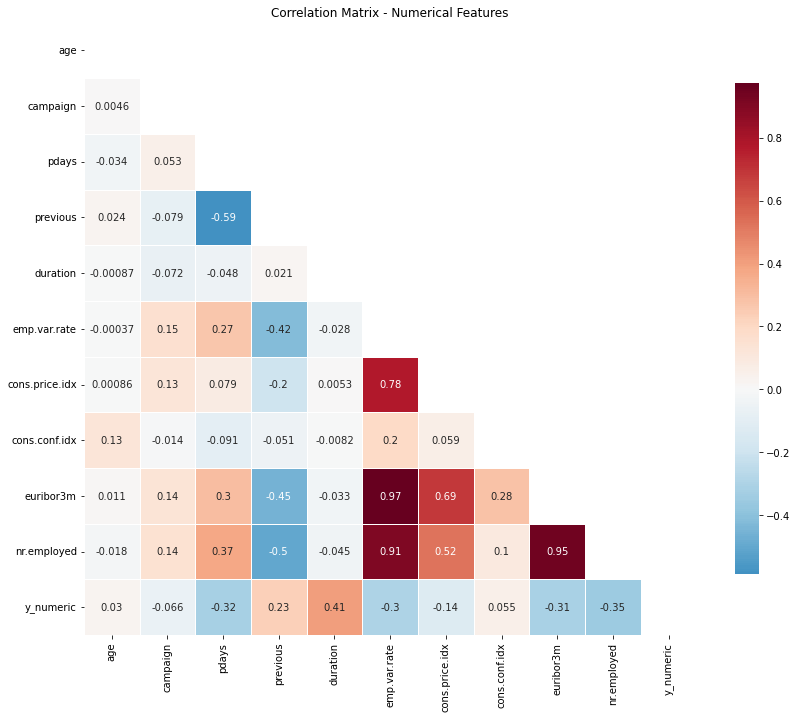

Correlation with target variable (y):
duration       :  0.405
nr.employed    : -0.355
pdays          : -0.325
euribor3m      : -0.308
emp.var.rate   : -0.298
previous       :  0.230
cons.price.idx : -0.136
campaign       : -0.066
cons.conf.idx  :  0.055
age            :  0.030


In [7]:
# Correlation matrix
corr_matrix = df[numerical_features + ['y']].copy()
corr_matrix['y_numeric'] = (corr_matrix['y'] == 'yes').astype(int)
corr_matrix = corr_matrix.drop('y', axis=1).corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features')
plt.tight_layout()
plt.show()

# Correlation with target
print("Correlation with target variable (y):")
target_correlations = corr_matrix['y_numeric'].drop('y_numeric').sort_values(key=abs, ascending=False)
for feature, corr in target_correlations.items():
    print(f"{feature:15}: {corr:6.3f}")

`Duration` is strongly predictive but unusable in real-time prediction.

`nr.employed`, `pdays`, `euribor3m` are important predictors.  
Conclusion: Good numerical predictors available, but must exclude duration.

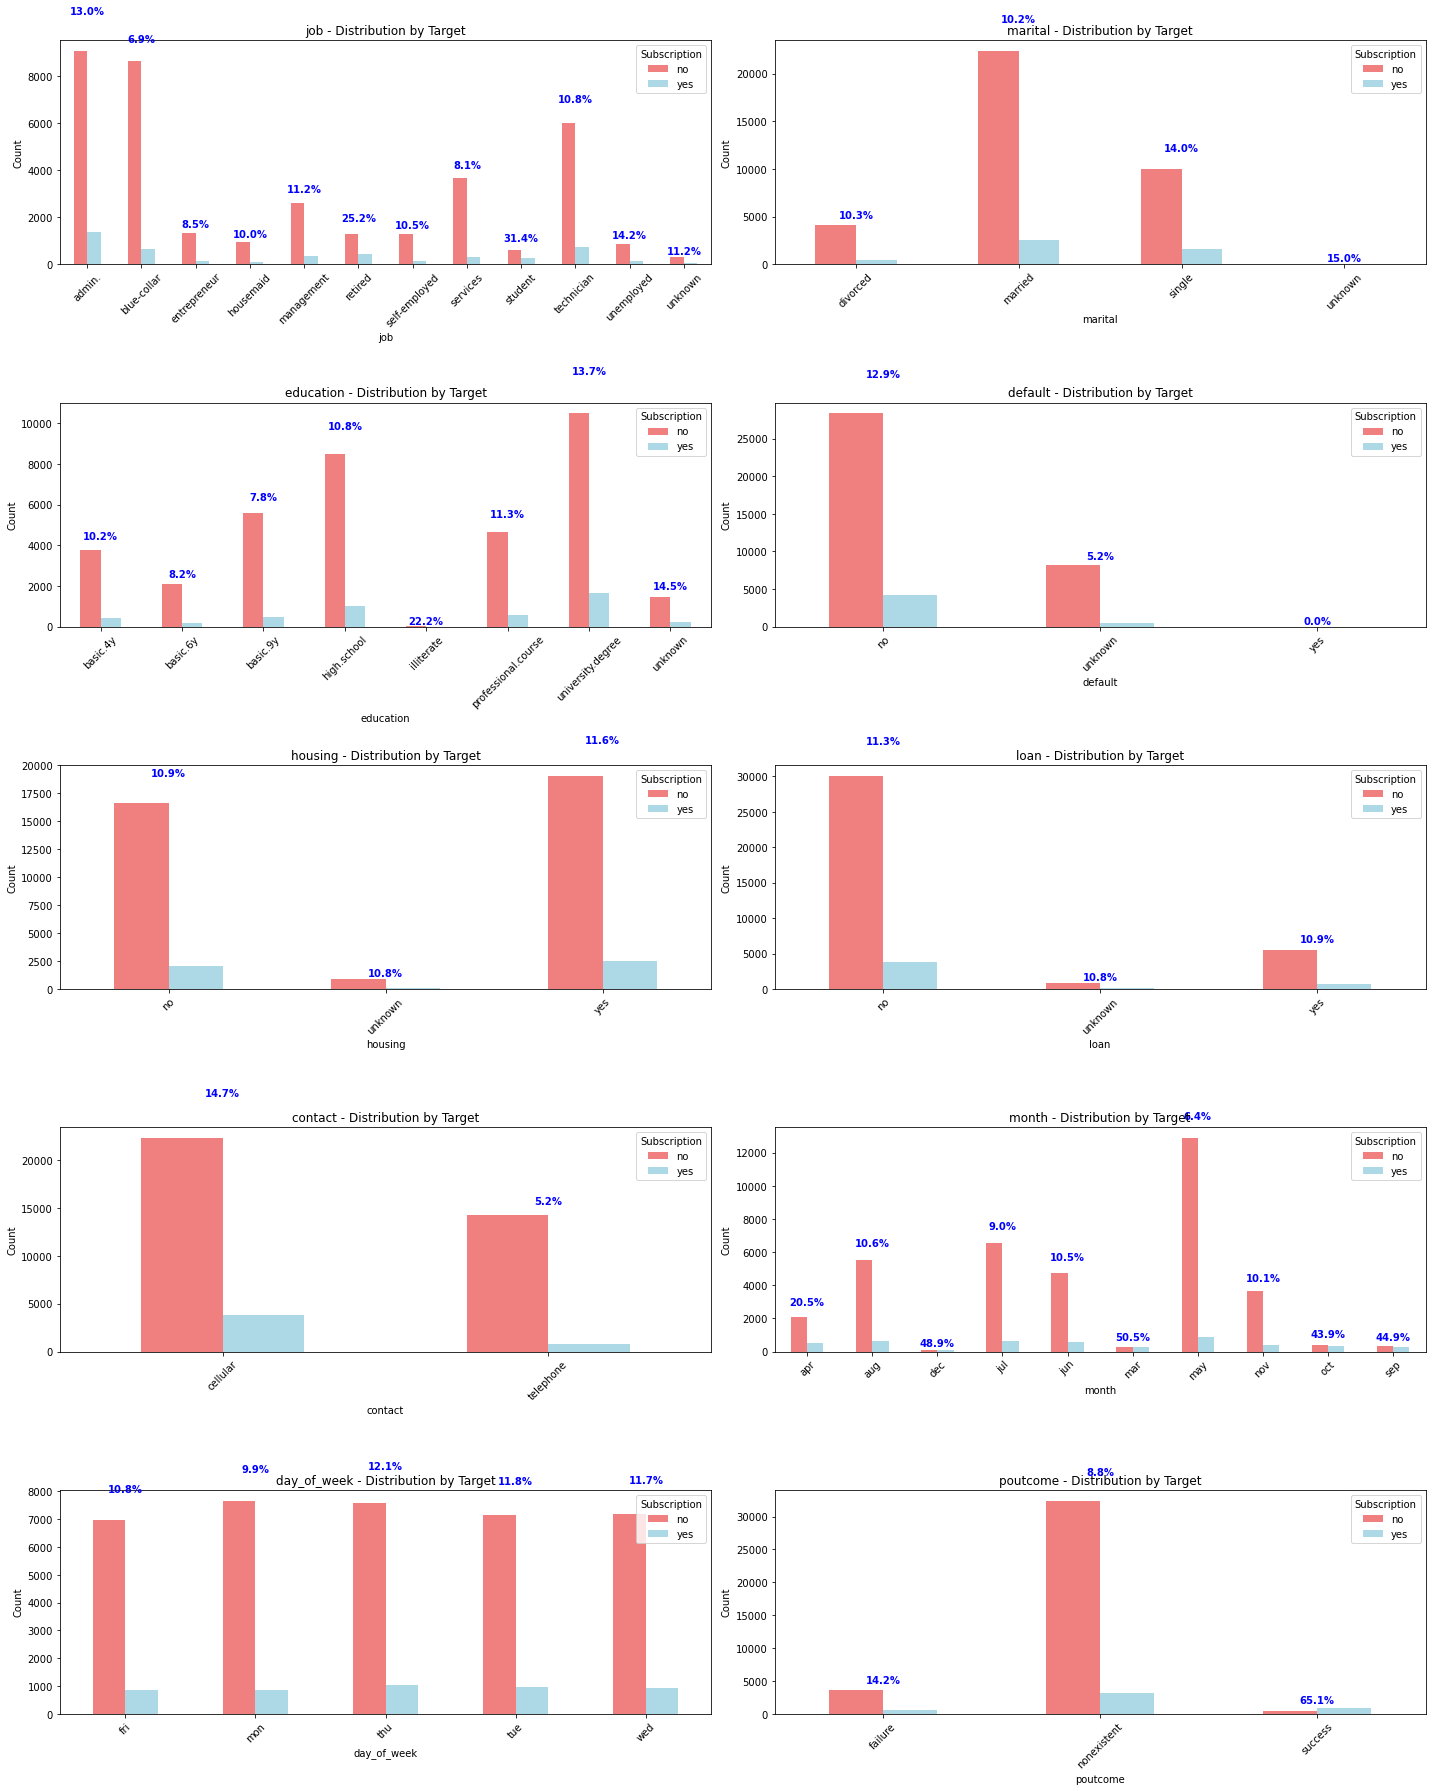

In [8]:
# 3. Categorical Features Analysis
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                       'contact', 'month', 'day_of_week', 'poutcome']

# Create subplots for categorical features
n_cat_features = len(categorical_features)
n_rows = (n_cat_features + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(20, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    # Cross-tabulation
    crosstab = pd.crosstab(df[feature], df['y'])
    crosstab_pct = pd.crosstab(df[feature], df['y'], normalize='index') * 100
    
    # Stacked bar plot
    crosstab.plot(kind='bar', ax=axes[i], color=['lightcoral', 'lightblue'])
    axes[i].set_title(f'{feature} - Distribution by Target')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Subscription')
    
    # Add percentage labels
    for j, (idx, row) in enumerate(crosstab.iterrows()):
        total = row.sum()
        yes_pct = crosstab_pct.loc[idx, 'yes']
        axes[i].text(j, total + total*0.01, f'{yes_pct:.1f}%', 
                    ha='center', va='bottom', fontweight='bold', color='blue')

# Remove empty subplots
for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [9]:
# Detailed categorical analysis with subscription rates
print("\nSubscription Rates by Categorical Features:")

for feature in categorical_features:
    print(f"\n{feature.upper()}:")
    crosstab_pct = pd.crosstab(df[feature], df['y'], normalize='index') * 100
    subscription_rate = crosstab_pct['yes'].sort_values(ascending=False)
    
    for category, rate in subscription_rate.items():
        count = df[df[feature] == category].shape[0]
        print(f"  {category:15}: {rate:5.1f}% subscription rate (n={count:,})")


Subscription Rates by Categorical Features:

JOB:
  student        :  31.4% subscription rate (n=875)
  retired        :  25.2% subscription rate (n=1,720)
  unemployed     :  14.2% subscription rate (n=1,014)
  admin.         :  13.0% subscription rate (n=10,422)
  management     :  11.2% subscription rate (n=2,924)
  unknown        :  11.2% subscription rate (n=330)
  technician     :  10.8% subscription rate (n=6,743)
  self-employed  :  10.5% subscription rate (n=1,421)
  housemaid      :  10.0% subscription rate (n=1,060)
  entrepreneur   :   8.5% subscription rate (n=1,456)
  services       :   8.1% subscription rate (n=3,969)
  blue-collar    :   6.9% subscription rate (n=9,254)

MARITAL:
  unknown        :  15.0% subscription rate (n=80)
  single         :  14.0% subscription rate (n=11,568)
  divorced       :  10.3% subscription rate (n=4,612)
  married        :  10.2% subscription rate (n=24,928)

EDUCATION:
  illiterate     :  22.2% subscription rate (n=18)
  unknown       

Students (31%) and retirees (25%) are much more likely to subscribe.

Cellular contact far outperforms telephone.

Previous campaign success = 65% subscription rate.

Conclusion: Strong categorical predictors, need robust encoding.

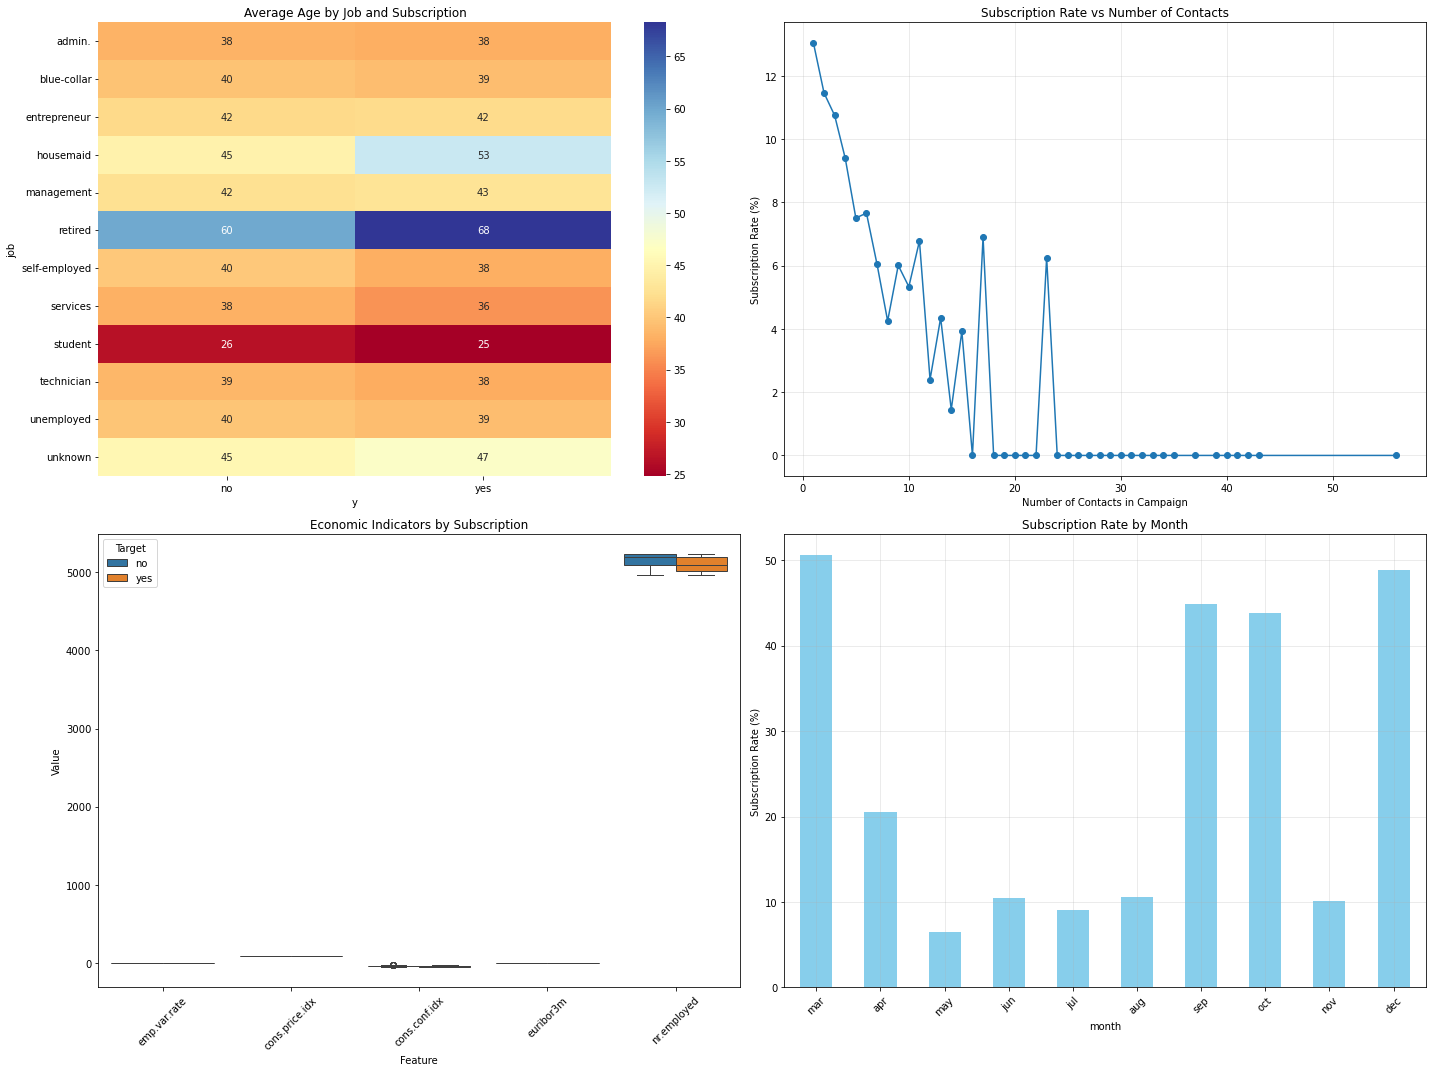

In [10]:
# 4. Advanced Visualizations

# Age vs Subscription with additional dimensions
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Age distribution by target and job
age_job_data = df.pivot_table(values='age', index='job', columns='y', aggfunc='mean')
sns.heatmap(age_job_data, annot=True, cmap='RdYlBu', ax=axes[0,0])
axes[0,0].set_title('Average Age by Job and Subscription')

# Campaign intensity analysis
campaign_target = pd.crosstab(df['campaign'], df['y'], normalize='index') * 100
campaign_target['yes'].plot(kind='line', ax=axes[0,1], marker='o')
axes[0,1].set_title('Subscription Rate vs Number of Contacts')
axes[0,1].set_xlabel('Number of Contacts in Campaign')
axes[0,1].set_ylabel('Subscription Rate (%)')
axes[0,1].grid(True, alpha=0.3)

# Economic indicators impact
economic_features = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
economic_corr = df[economic_features + ['duration']].copy()
economic_corr['y_numeric'] = (df['y'] == 'yes').astype(int)

# Box plots for economic indicators
economic_data = []
for feature in economic_features:
    for target_val in ['no', 'yes']:
        values = df[df['y'] == target_val][feature]
        economic_data.extend([(feature, target_val, val) for val in values.sample(min(1000, len(values)))])

economic_df = pd.DataFrame(economic_data, columns=['Feature', 'Target', 'Value'])
sns.boxplot(data=economic_df, x='Feature', y='Value', hue='Target', ax=axes[1,0])
axes[1,0].set_title('Economic Indicators by Subscription')
axes[1,0].tick_params(axis='x', rotation=45)

# Month seasonality analysis
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
monthly_data = df.copy()
monthly_data['month'] = pd.Categorical(monthly_data['month'], categories=month_order, ordered=True)
monthly_sub_rate = pd.crosstab(monthly_data['month'], monthly_data['y'], normalize='index')['yes'] * 100

monthly_sub_rate.plot(kind='bar', ax=axes[1,1], color='skyblue')
axes[1,1].set_title('Subscription Rate by Month')
axes[1,1].set_ylabel('Subscription Rate (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Campaign intensity and seasonality patterns confirmed.

Conclusion: Useful insights, supports business understanding.

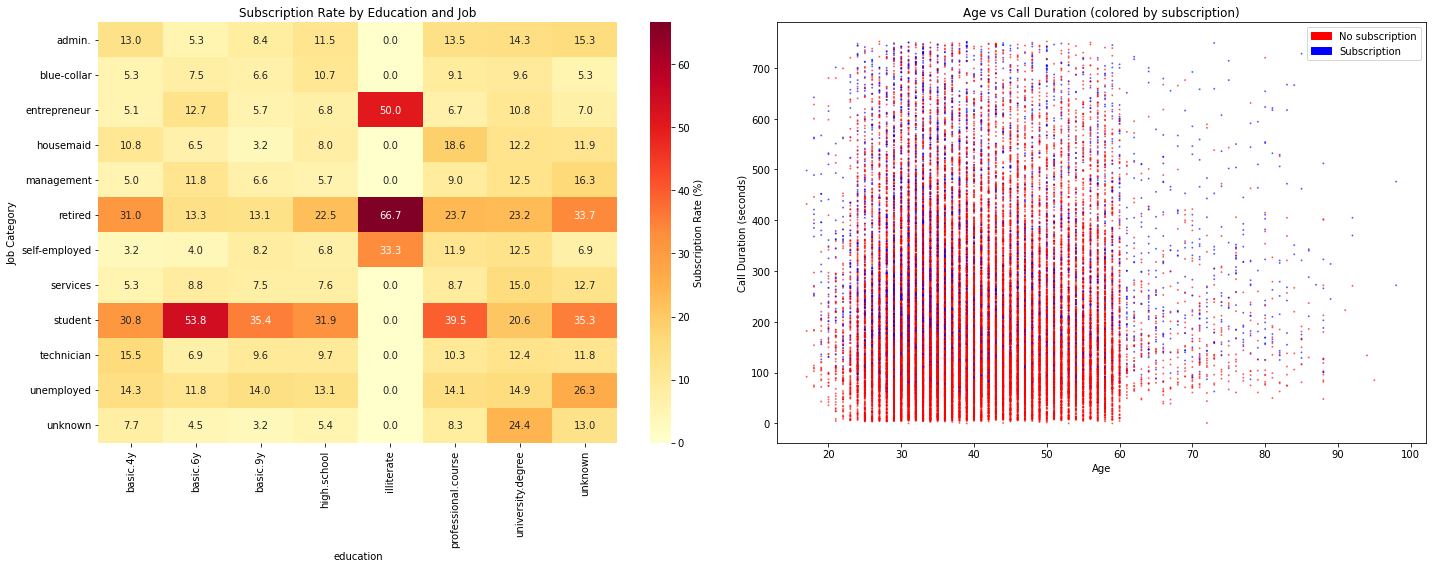

In [11]:
# 5. Feature Interaction Analysis

# Education vs Job subscription rates
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap of subscription rates
education_job = pd.crosstab([df['education'], df['job']], df['y'], normalize='index')['yes'] * 100
education_job_pivot = education_job.unstack(level=0)

# Plot only if we have data
if not education_job_pivot.empty:
    sns.heatmap(education_job_pivot.fillna(0), annot=True, cmap='YlOrRd', 
               ax=axes[0], fmt='.1f', cbar_kws={'label': 'Subscription Rate (%)'})
    axes[0].set_title('Subscription Rate by Education and Job')
    axes[0].set_ylabel('Job Category')

# Age vs Duration (excluding outliers for better visualization)
duration_clean = df[df['duration'] < df['duration'].quantile(0.95)]  # Remove top 5% outliers
scatter_colors = ['red' if x == 'no' else 'blue' for x in duration_clean['y']]
axes[1].scatter(duration_clean['age'], duration_clean['duration'], 
               c=scatter_colors, alpha=0.5, s=1)
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Call Duration (seconds)')
axes[1].set_title('Age vs Call Duration (colored by subscription)')

# Create custom legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='No subscription')
blue_patch = mpatches.Patch(color='blue', label='Subscription')
axes[1].legend(handles=[red_patch, blue_patch])

plt.tight_layout()
plt.show()


`Education` × `Job` interaction matters.

`Age` × `Duration` confirms duration’s bias.

Conclusion: Feature interactions could be engineered into new variables.

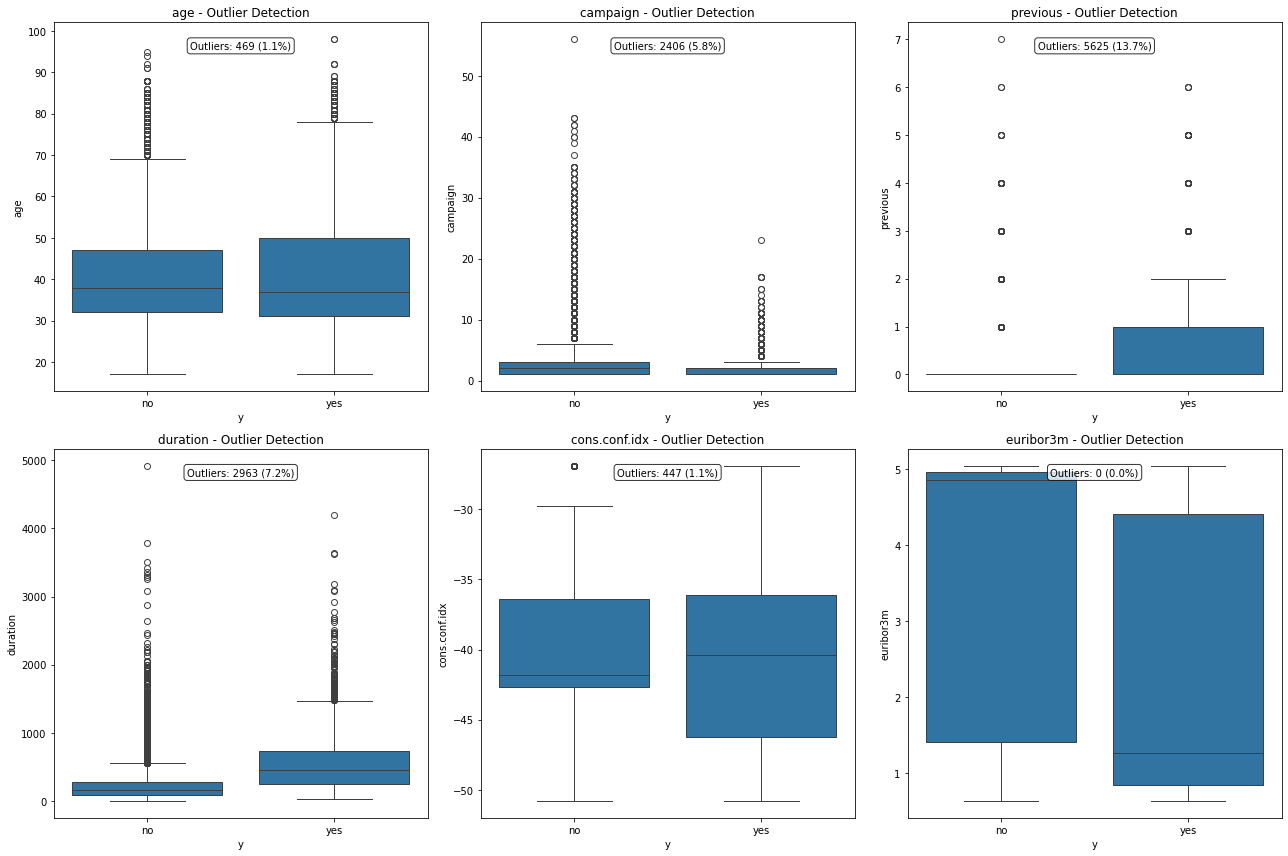

In [12]:
# 6. Outlier Analysis

# Box plots for key numerical features to identify outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

outlier_features = ['age', 'campaign', 'previous', 'duration', 'cons.conf.idx', 'euribor3m']

for i, feature in enumerate(outlier_features):
    sns.boxplot(data=df, x='y', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} - Outlier Detection')
    
    # Calculate and display outlier statistics
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).sum()
    axes[i].text(0.5, 0.95, f'Outliers: {outliers} ({outliers/len(df)*100:.1f}%)', 
                transform=axes[i].transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Many outliers in `campaign`, `previous`, `duration`.

- Decision: keep them since they might reflect real behavior.  
- Conclusion: Reasonable, though robust models may help.

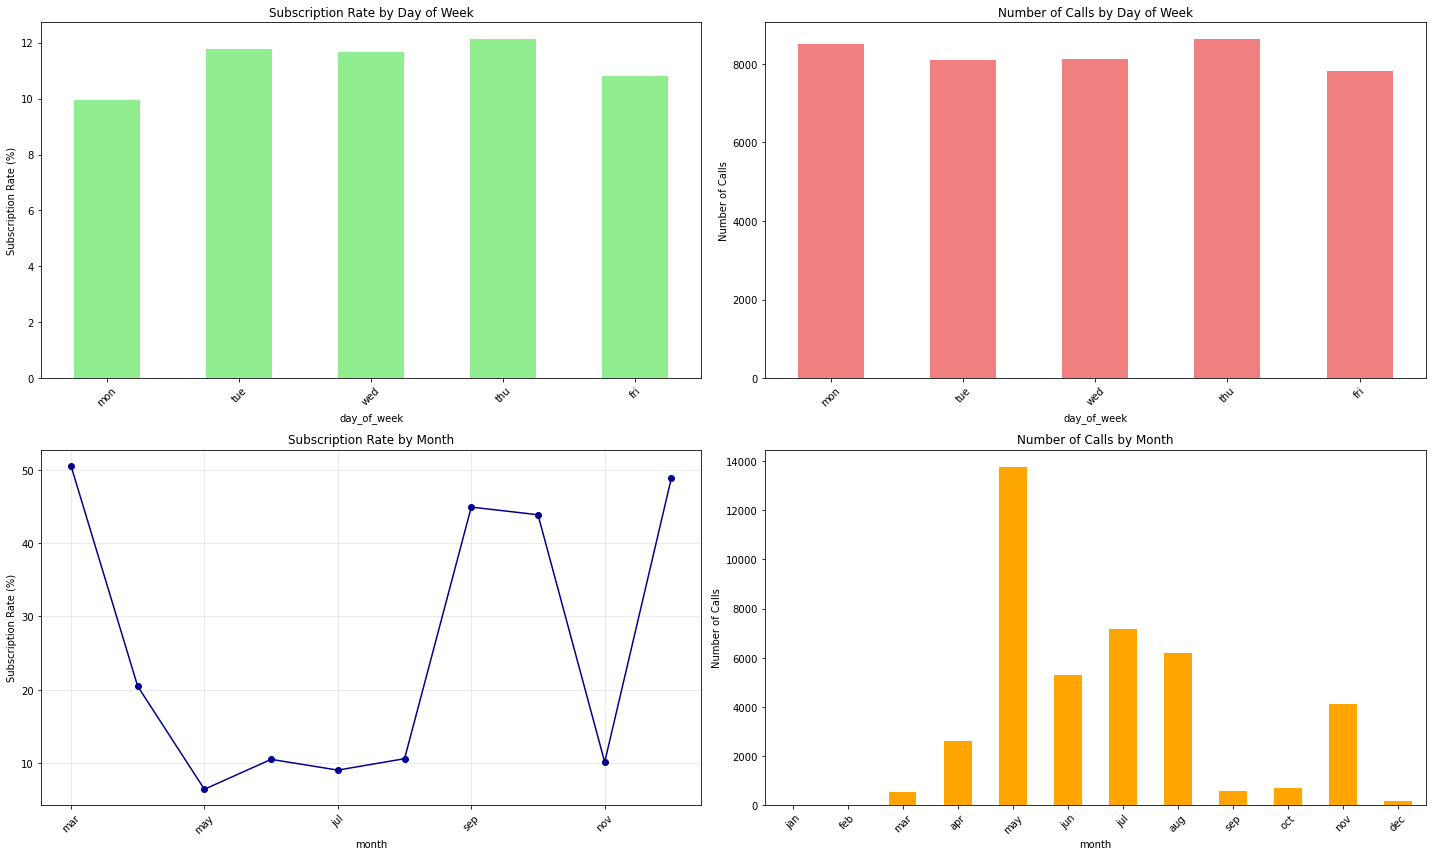

In [13]:
# 7. Time-based Analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Day of week analysis
day_order = ['mon', 'tue', 'wed', 'thu', 'fri']
day_data = df.copy()
day_data['day_of_week'] = pd.Categorical(day_data['day_of_week'], categories=day_order, ordered=True)

# Subscription rate by day
day_sub_rate = pd.crosstab(day_data['day_of_week'], day_data['y'], normalize='index')['yes'] * 100
day_sub_rate.plot(kind='bar', ax=axes[0,0], color='lightgreen')
axes[0,0].set_title('Subscription Rate by Day of Week')
axes[0,0].set_ylabel('Subscription Rate (%)')
axes[0,0].tick_params(axis='x', rotation=45)

# Call volume by day
day_counts = df['day_of_week'].value_counts().reindex(day_order)
day_counts.plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Number of Calls by Day of Week')
axes[0,1].set_ylabel('Number of Calls')
axes[0,1].tick_params(axis='x', rotation=45)

# Monthly analysis
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
monthly_data = df.copy()
monthly_data['month'] = pd.Categorical(monthly_data['month'], categories=month_order, ordered=True)

# Subscription rate by month
monthly_sub_rate = pd.crosstab(monthly_data['month'], monthly_data['y'], normalize='index')['yes'] * 100
monthly_sub_rate.plot(kind='line', ax=axes[1,0], marker='o', color='darkblue')
axes[1,0].set_title('Subscription Rate by Month')
axes[1,0].set_ylabel('Subscription Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Call volume by month
monthly_counts = df['month'].value_counts().reindex(month_order)
monthly_counts.plot(kind='bar', ax=axes[1,1], color='orange')
axes[1,1].set_title('Number of Calls by Month')
axes[1,1].set_ylabel('Number of Calls')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


- Subscription rates vary by month; May has lowest rates.  
- Conclusion: Seasonality is relevant, time features should be kept.

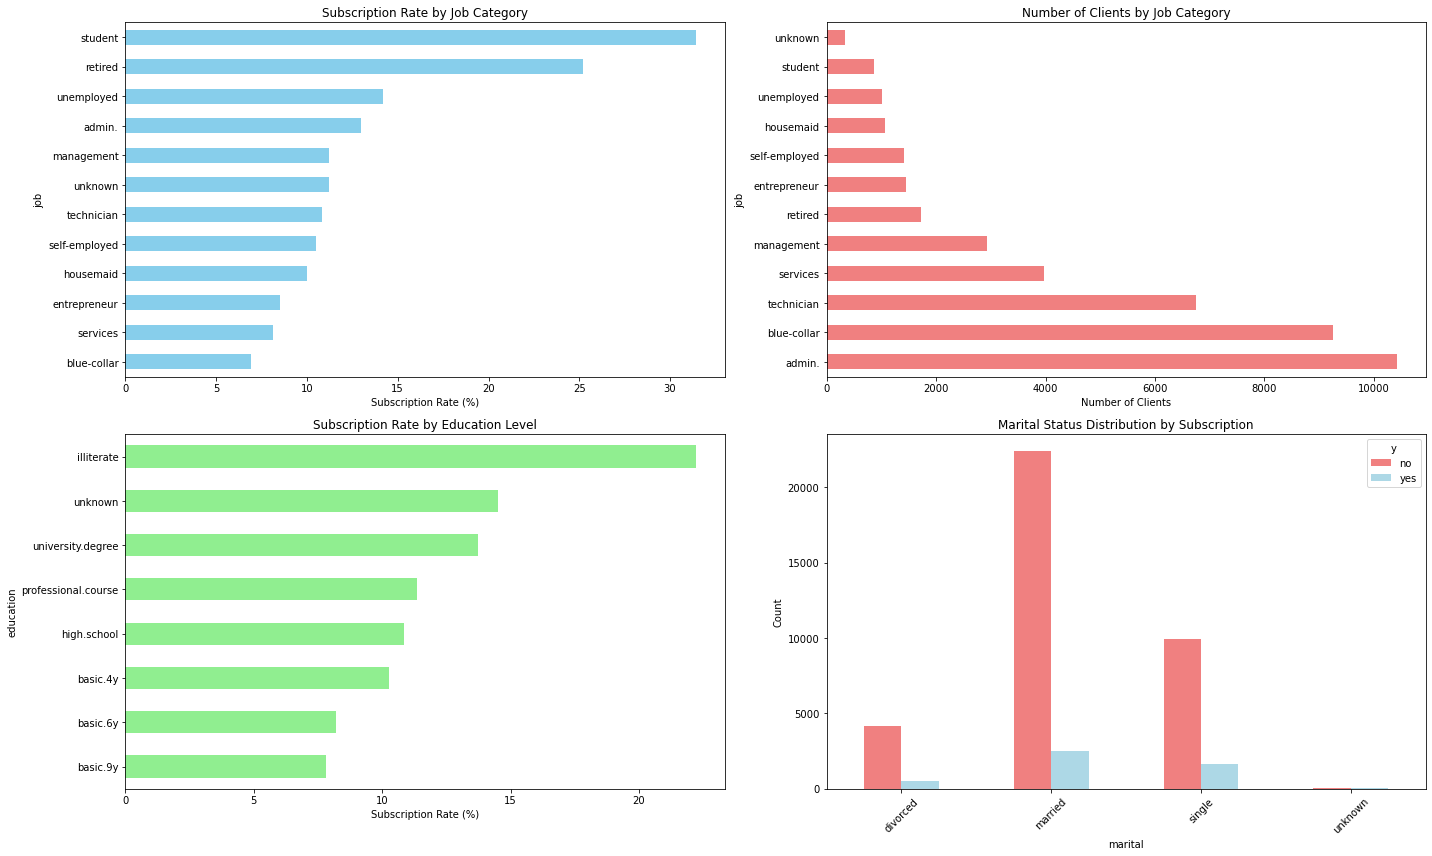

In [14]:
# 8. Demographic Analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Job analysis with subscription rates
job_analysis = pd.crosstab(df['job'], df['y'])
job_sub_rate = pd.crosstab(df['job'], df['y'], normalize='index')['yes'] * 100

# Job subscription rates
job_sub_rate.sort_values(ascending=True).plot(kind='barh', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Subscription Rate by Job Category')
axes[0,0].set_xlabel('Subscription Rate (%)')

# Job counts
job_counts = df['job'].value_counts()
job_counts.plot(kind='barh', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Number of Clients by Job Category')
axes[0,1].set_xlabel('Number of Clients')

# Education analysis
education_sub_rate = pd.crosstab(df['education'], df['y'], normalize='index')['yes'] * 100
education_sub_rate.sort_values(ascending=True).plot(kind='barh', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Subscription Rate by Education Level')
axes[1,0].set_xlabel('Subscription Rate (%)')

# Marital status
marital_analysis = pd.crosstab(df['marital'], df['y'])
marital_analysis.plot(kind='bar', ax=axes[1,1], color=['lightcoral', 'lightblue'])
axes[1,1].set_title('Marital Status Distribution by Subscription')
axes[1,1].set_ylabel('Count')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- `Jobs`, `education`, and `marital` status show clear subscription differences.

- Conclusion: Demographics are highly predictive.

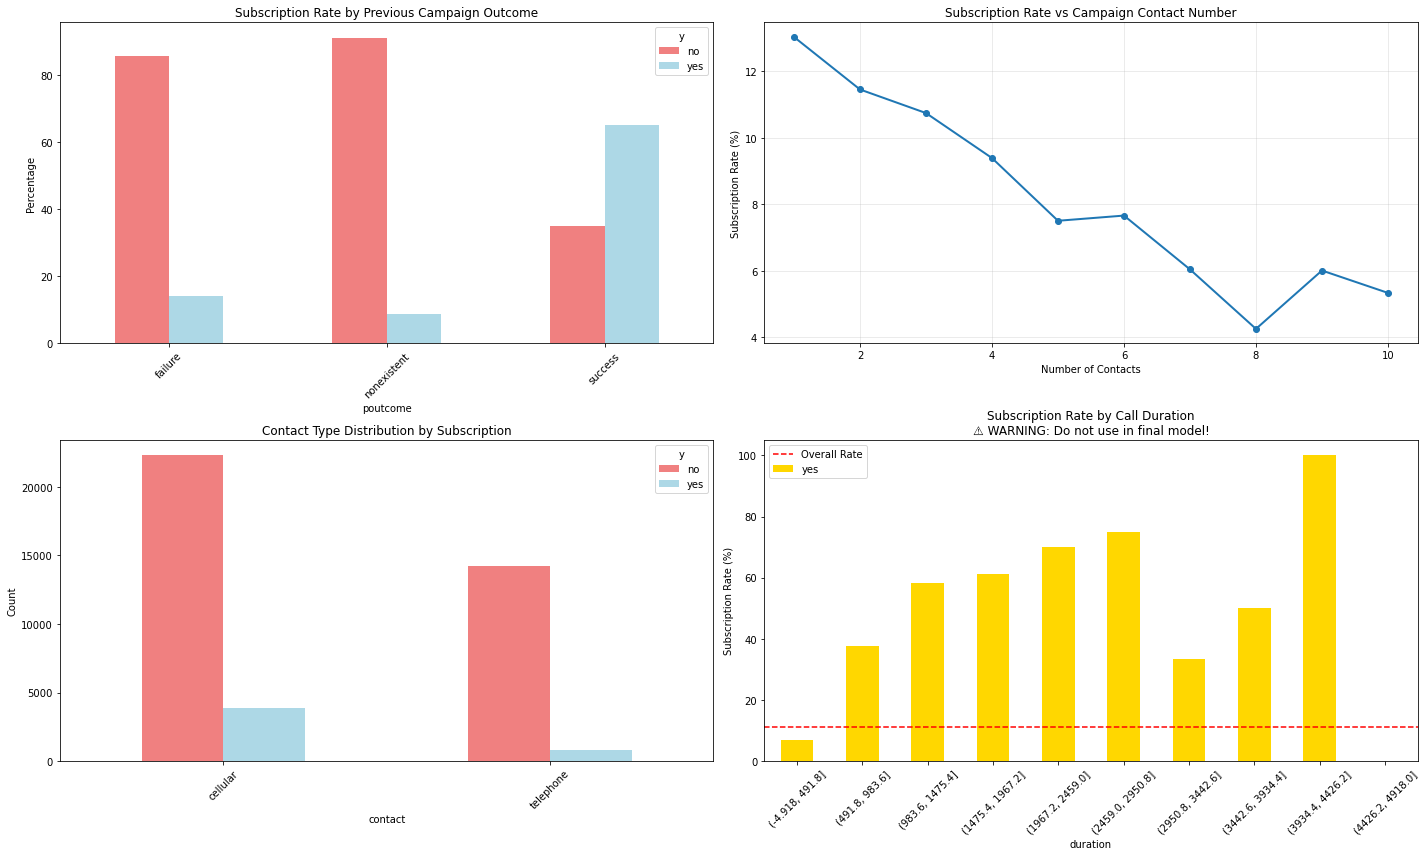

In [16]:
# 9. Campaign Analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Previous campaign outcome impact
poutcome_analysis = pd.crosstab(df['poutcome'], df['y'], normalize='index') * 100
poutcome_analysis.plot(kind='bar', ax=axes[0,0], color=['lightcoral', 'lightblue'])
axes[0,0].set_title('Subscription Rate by Previous Campaign Outcome')
axes[0,0].set_ylabel('Percentage')
axes[0,0].tick_params(axis='x', rotation=45)

# Campaign number vs success rate
campaign_success = df.groupby('campaign').agg({
    'y': lambda x: (x == 'yes').mean() * 100
}).reset_index()
campaign_success = campaign_success[campaign_success['campaign'] <= 10]  # Focus on reasonable campaign numbers

axes[0,1].plot(
    campaign_success['campaign'].to_numpy(),
    campaign_success['y'].to_numpy(),
    marker='o',
    linewidth=2
)
axes[0,1].set_title('Subscription Rate vs Campaign Contact Number')
axes[0,1].set_xlabel('Number of Contacts')
axes[0,1].set_ylabel('Subscription Rate (%)')
axes[0,1].grid(True, alpha=0.3)

# Contact type analysis
contact_analysis = pd.crosstab(df['contact'], df['y'])
contact_analysis.plot(kind='bar', ax=axes[1,0], color=['lightcoral', 'lightblue'])
axes[1,0].set_title('Contact Type Distribution by Subscription')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Duration analysis (important note about not using in final model)
duration_bins = pd.cut(df['duration'], bins=10)
duration_analysis = pd.crosstab(duration_bins, df['y'], normalize='index')['yes'] * 100
duration_analysis.plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Subscription Rate by Call Duration\n⚠️ WARNING: Do not use in final model!')
axes[1,1].set_ylabel('Subscription Rate (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].axhline(y=df['y'].value_counts(normalize=True)['yes'] * 100, 
                 color='red', linestyle='--', label='Overall Rate')
axes[1,1].legend()

plt.tight_layout()
plt.show()


- Too many contacts reduce subscription success. 

- Conclusion: Campaign intensity features are valuable.

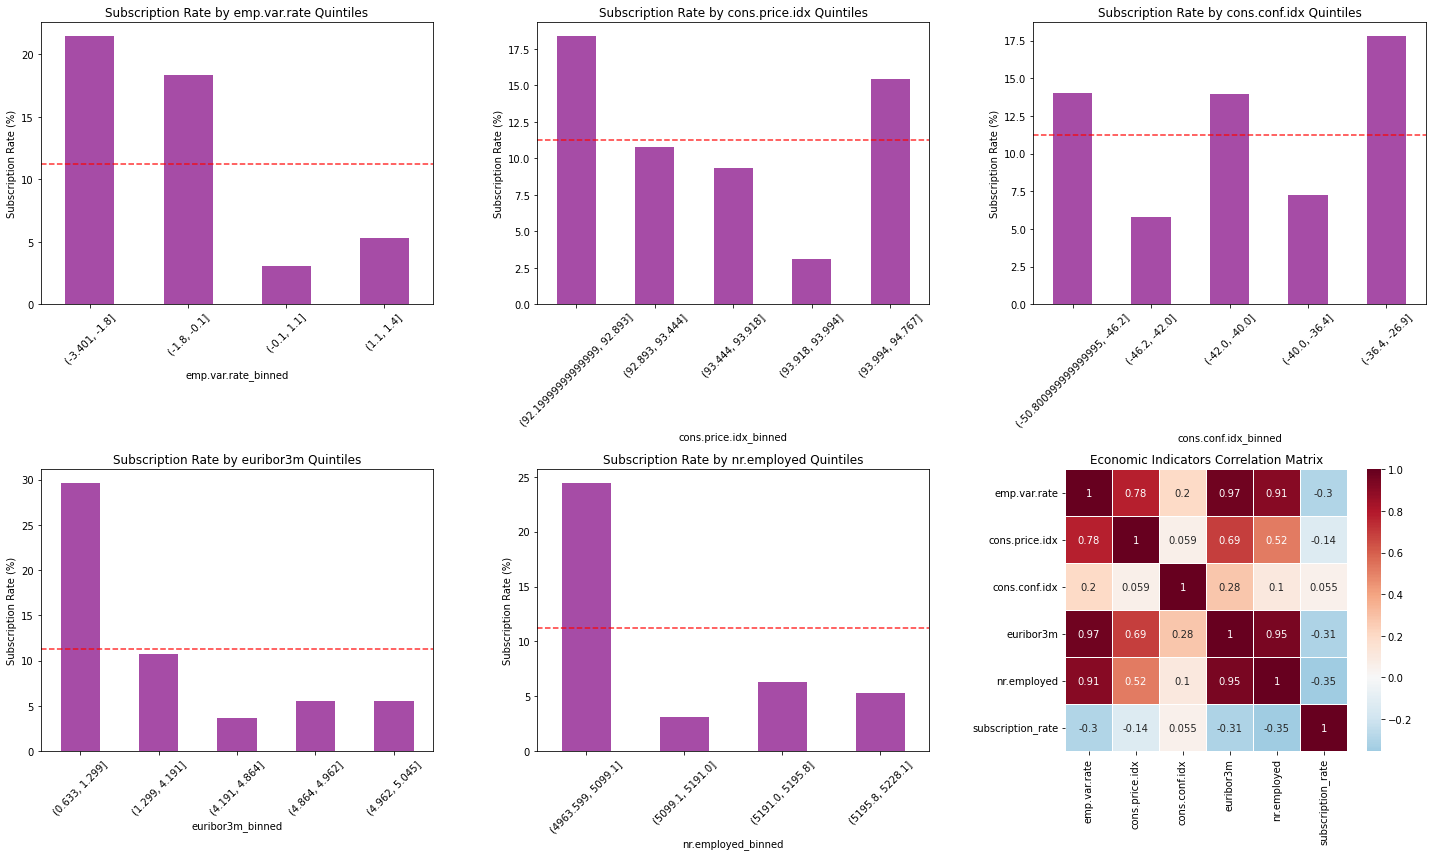

In [17]:
# 10. Economic Context Analysis

# Economic indicators correlation and impact
economic_features = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, feature in enumerate(economic_features):
    # Create bins for better visualization
    df_temp = df.copy()
    df_temp[f'{feature}_binned'] = pd.qcut(df_temp[feature], q=5, duplicates='drop')
    
    # Subscription rate by economic indicator bins
    econ_sub_rate = pd.crosstab(df_temp[f'{feature}_binned'], df_temp['y'], normalize='index')['yes'] * 100
    econ_sub_rate.plot(kind='bar', ax=axes[i], color='purple', alpha=0.7)
    axes[i].set_title(f'Subscription Rate by {feature} Quintiles')
    axes[i].set_ylabel('Subscription Rate (%)')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].axhline(y=df['y'].value_counts(normalize=True)['yes'] * 100, 
                   color='red', linestyle='--', alpha=0.8, label='Overall Rate')

# Economic indicators heatmap
economic_df = df[economic_features].copy()
economic_df['subscription_rate'] = (df['y'] == 'yes').astype(int)
economic_corr_matrix = economic_df.corr()

sns.heatmap(economic_corr_matrix, annot=True, cmap='RdBu_r', center=0,
           square=True, linewidths=0.5, ax=axes[5])
axes[5].set_title('Economic Indicators Correlation Matrix')

plt.tight_layout()
plt.show()



- Strong effects from `emp.var.rate`, `euribor3m`, `nr.employed`.

- Conclusion: Economic context is critical to predictions.

KEY FINDINGS FROM EDA:

 CLASS IMBALANCE:
- Severe imbalance: 'no'- 89% vs 'yes' - 11% 
- This will require oversampling techniques and careful metric selection

 DEMOGRAPHIC PATTERNS:
- Students and retired clients show higher subscription rates
- University degree holders more likely to subscribe
- Single clients have different patterns than married/divorced

 CAMPAIGN PATTERNS:
- Previous campaign success strongly predicts current success
- Cellular contact more effective than telephone
- Too many contacts (>3) in current campaign reduces success rate
- May campaigns show highest subscription rates

 ECONOMIC CONTEXT:
- Economic indicators show strong correlations with subscription behavior
- Lower employment variation rate correlates with higher subscriptions
- Consumer confidence index impacts decision making

 DURATION WARNING:
- Call duration strongly predicts outcome (longer calls = more subscriptions)
- BUT: Duration known only AFTER call outcome, so cannot use in prediction model
- This will be excluded from final model as specified in requirements

 FEATURE ENGINEERING OPPORTUNITIES:
- Age groups show different patterns
- Job categories can be grouped into broader classes
- Economic sentiment composite feature could be valuable
- Previous contact history is highly predictive

### Hypotheses about Feature Impact:

1. AGE: Middle-aged clients (30-50) might be more likely to subscribe due to financial stability
2. JOB: Management, technician, and retired clients may have higher subscription rates
3. EDUCATION: Higher education levels might correlate with better financial awareness and subscription
4. DURATION: Longer call duration strongly indicates interest (but note: this shouldn't be in final model)
5. CAMPAIGN: Too many contacts in current campaign might decrease subscription probability
6. PDAYS: Recent contact from previous campaign might increase subscription likelihood
7. POUTCOME: Previous campaign success strongly indicates current campaign success
8. MONTH: Certain months might have seasonal effects on subscription rates
9. ECONOMIC INDICATORS: Better economic conditions might increase subscription rates
10. CONTACT TYPE: Cellular contact might be more effective than telephone

## 3. Methodology and Metrics Selection

CHOSEN METRICS:
1. PRIMARY: F1-Score - balances precision and recall, important for imbalanced dataset
2. SECONDARY: ROC-AUC - measures model's ability to distinguish between classes
3. ADDITIONAL: Precision and Recall for business context

JUSTIFICATION:
- Dataset is imbalanced (more 'no' than 'yes' responses)
- False positives (predicting subscription when customer won't subscribe) waste marketing resources
- False negatives (missing potential subscribers) lose revenue opportunities
- F1-score provides balanced view of both precision and recall
- ROC-AUC helps evaluate model's discriminative ability across all thresholds

MODELS TO COMPARE:
1. Logistic Regression - baseline, interpretable
2. k-NN - non-parametric, good for local patterns
3. Decision Tree - interpretable, handles non-linear relationships
4. Gradient Boosting - ensemble method, typically high performance


## 4. Data Preprocessing

In [18]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle 'unknown' values - treat as separate category or group with most similar

# For some features, 'unknown' might be informative, for others we might group them
# Let's analyze the distribution of unknowns
unknown_counts = {}
for col in categorical_features:
    unknown_count = (df_processed[col] == 'unknown').sum()
    unknown_counts[col] = unknown_count
    print(f"{col}: {unknown_count} unknowns ({unknown_count/len(df_processed)*100:.1f}%)")

# Handle pdays (999 means no previous contact)
df_processed['pdays_contacted'] = (df_processed['pdays'] != 999).astype(int)
df_processed['pdays_clean'] = df_processed['pdays'].replace(999, 0)

job: 330 unknowns (0.8%)
marital: 80 unknowns (0.2%)
education: 1731 unknowns (4.2%)
default: 8597 unknowns (20.9%)
housing: 990 unknowns (2.4%)
loan: 990 unknowns (2.4%)
contact: 0 unknowns (0.0%)
month: 0 unknowns (0.0%)
day_of_week: 0 unknowns (0.0%)
poutcome: 0 unknowns (0.0%)


1. Low frequency unknowns (< 1%) - can be grouped with most similar category or mode  
- `job`: 0.8% unknowns - group with most common job
- `marital`: 0.2% unknowns - group with most common status

In [19]:
most_common_job = df_processed[df_processed['job'] != 'unknown']['job'].mode()[0]
df_processed['job'] = df_processed['job'].replace('unknown', most_common_job)

most_common_marital = df_processed[df_processed['marital'] != 'unknown']['marital'].mode()[0]
df_processed['marital'] = df_processed['marital'].replace('unknown', most_common_marital)

2. Medium frequency unknowns (2-5%) - keep as separate category or use predictive imputation  
- `education`: 4.2% unknowns - keep as separate category (might be informative)
- `housing`: 2.4% unknowns - keep as separate category
- `loan`: 2.4% unknowns - keep as separate category

3. High frequency unknowns (20%+) - definitely keep as separate category
- `default`: 20.9% unknowns - this is very informative, keep as separate category

In [20]:
print("After handling low-frequency unknowns:")
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    unknown_count = (df_processed[col] == 'unknown').sum()
    print(f"{col}: {unknown_count} unknowns")

After handling low-frequency unknowns:
job: 0 unknowns
marital: 0 unknowns
education: 1731 unknowns
default: 8597 unknowns
housing: 990 unknowns
loan: 990 unknowns


In [21]:
# Create additional features
# Age groups
df_processed['age_group'] = pd.cut(df_processed['age'], 
                                  bins=[0, 25, 35, 50, 65, 100], 
                                  labels=['young', 'young_adult', 'middle', 'senior', 'elderly'])

# Campaign intensity
df_processed['campaign_intensity'] = pd.cut(df_processed['campaign'], 
                                           bins=[0, 1, 3, 6, float('inf')], 
                                           labels=['single', 'few', 'several', 'many'])

# Combine economic indicators)
scaler_temp = StandardScaler()
economic_features = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
df_processed['economic_sentiment'] = scaler_temp.fit_transform(df_processed[economic_features]).mean(axis=1)

# Education grouping (simplify categories)
education_mapping = {
    'basic.4y': 'basic', 'basic.6y': 'basic', 'basic.9y': 'basic',
    'high.school': 'secondary', 'professional.course': 'secondary',
    'university.degree': 'higher', 'illiterate': 'basic', 'unknown': 'unknown'
}
df_processed['education_grouped'] = df_processed['education'].map(education_mapping)

# Job grouping
job_mapping = {
    'admin.': 'white_collar', 'management': 'white_collar', 'technician': 'white_collar',
    'services': 'services', 'blue-collar': 'blue_collar', 'housemaid': 'services',
    'entrepreneur': 'entrepreneur', 'self-employed': 'entrepreneur',
    'retired': 'retired', 'student': 'student', 'unemployed': 'unemployed', 'unknown': 'unknown'
}
df_processed['job_grouped'] = df_processed['job'].map(job_mapping)

In [22]:
# Outlier detection
numerical_cols = ['age', 'campaign', 'previous', 'duration'] + economic_features

for col in numerical_cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(df_processed)*100:.1f}%)")

age: 469 outliers (1.1%)
campaign: 2406 outliers (5.8%)
previous: 5625 outliers (13.7%)
duration: 2963 outliers (7.2%)
emp.var.rate: 0 outliers (0.0%)
cons.price.idx: 0 outliers (0.0%)
cons.conf.idx: 447 outliers (1.1%)
euribor3m: 0 outliers (0.0%)
nr.employed: 0 outliers (0.0%)


- For this project, we'll keep outliers as they might be meaningful (e.g., very long calls might indicate high interest)

- “Unknown” values handled sensibly (sometimes grouped, sometimes retained).

- Feature engineering (age groups, campaign intensity, economic sentiment).

## 5. Model Training and Evaluation

In [23]:
# Prepare features for modeling
# IMPORTANT: Exclude 'duration' as mentioned in the assignment
features_to_exclude = ['duration', 'y']

In [24]:
# Select features for modeling
numerical_features_final = ['age', 'campaign', 'pdays_clean', 'previous', 'pdays_contacted',
                           'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 
                           'nr.employed', 'economic_sentiment']

categorical_features_final = ['job_grouped', 'marital', 'education_grouped', 'default', 
                             'housing', 'loan', 'contact', 'month', 'day_of_week', 
                             'poutcome', 'age_group', 'campaign_intensity']

In [25]:
# Prepare X and y
X = df_processed[numerical_features_final + categorical_features_final]
y = (df_processed['y'] == 'yes').astype(int)  # Convert to binary

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (26360, 23)
Validation set: (6590, 23)
Test set: (8238, 23)


In [26]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_final),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_final)
    ])

In [27]:
# Preprocess the training data for oversampling
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"\nProcessed training data shape: {X_train_processed.shape}")


Processed training data shape: (26360, 63)


### Apply different oversampling techniques

In [28]:
# 1. SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42, k_neighbors=3)  # Reduce k_neighbors due to small minority class
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
print(f"After SMOTE: {Counter(y_train_smote)}")

After SMOTE: Counter({1: 23390, 0: 23390})


In [29]:
# 2. ADASYN (Adaptive Synthetic Sampling)
adasyn = ADASYN(random_state=42, n_neighbors=3)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_processed, y_train)
print(f"After ADASYN: {Counter(y_train_adasyn)}")
adasyn_available = True

After ADASYN: Counter({0: 23390, 1: 23324})


In [30]:
# 3. Random OverSampler (as backup or alternative)
random_oversampler = RandomOverSampler(random_state=42)
X_train_random, y_train_random = random_oversampler.fit_resample(X_train_processed, y_train)
print(f"After Random OverSampling: {Counter(y_train_random)}")

After Random OverSampling: Counter({1: 23390, 0: 23390})


In [31]:
def evaluate_model_with_oversampling(model, X_train_resampled, X_val, y_train_resampled, y_val, model_name, sampling_method="Original"):
    # Fit the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predictions
    train_pred = model.predict(X_train_resampled)
    val_pred = model.predict(X_val)
    
    # Probabilities for AUC
    if hasattr(model, 'predict_proba'):
        train_proba = model.predict_proba(X_train_resampled)[:, 1]
        val_proba = model.predict_proba(X_val)[:, 1]
    else:
        train_proba = train_pred
        val_proba = val_pred
    
    # Calculate metrics
    train_metrics = {
        'accuracy': accuracy_score(y_train_resampled, train_pred),
        'precision': precision_score(y_train_resampled, train_pred),
        'recall': recall_score(y_train_resampled, train_pred),
        'f1': f1_score(y_train_resampled, train_pred),
        'auc': roc_auc_score(y_train_resampled, train_proba)
    }
    
    val_metrics = {
        'accuracy': accuracy_score(y_val, val_pred),
        'precision': precision_score(y_val, val_pred),
        'recall': recall_score(y_val, val_pred),
        'f1': f1_score(y_val, val_pred),
        'auc': roc_auc_score(y_val, val_proba)
    }
    
    print(f"{model_name} ({sampling_method}) - Val F1: {val_metrics['f1']:.4f}, Val AUC: {val_metrics['auc']:.4f}, Val Recall: {val_metrics['recall']:.4f}")
    
    return train_metrics, val_metrics

In [32]:
# Test different sampling strategies for each model
sampling_strategies = [
    ("Original", X_train_processed, y_train),
    ("SMOTE", X_train_smote, y_train_smote),
    ("Random_OS", X_train_random, y_train_random),
]

# Add ADASYN if available
if adasyn_available:
    sampling_strategies.append(("ADASYN", X_train_adasyn, y_train_adasyn))

# 1. Logistic Regression

In [79]:
# Initialize results storage
results = []

In [80]:
for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    
    train_metrics, val_metrics = evaluate_model_with_oversampling(
        lr_model, X_train_resampled, X_val_processed, y_train_resampled, y_val, 
        'Logistic Regression', sampling_name
    )
    
    results.append({
        'Model': f'LR_{sampling_name}',
        'Hyperparameters': f'C=1.0, class_weight=balanced, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}",
        'Trained_Model': lr_model
    })

Logistic Regression (Original) - Val F1: 0.4494, Val AUC: 0.7981, Val Recall: 0.6321
Logistic Regression (SMOTE) - Val F1: 0.4484, Val AUC: 0.7943, Val Recall: 0.6348
Logistic Regression (Random_OS) - Val F1: 0.4511, Val AUC: 0.7978, Val Recall: 0.6307
Logistic Regression (ADASYN) - Val F1: 0.3990, Val AUC: 0.7903, Val Recall: 0.6712


### Conclusion
Before Oversampling: Logistic Regression shows good discrimination (AUC ≈ 0.79) but poor F1 (≈ 0.34), indicating the need for threshold tuning or class imbalance handling.

# 2. k-NN

In [81]:
for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    # Use subset for k-NN to maintain speed
    subset_size = min(8000, len(X_train_resampled))  
    subset_indices = np.random.choice(len(X_train_resampled), subset_size, replace=False)
    X_train_subset = X_train_resampled[subset_indices]
    y_train_subset = y_train_resampled.iloc[subset_indices] if hasattr(y_train_resampled, 'iloc') else y_train_resampled[subset_indices]
    
    knn_model = KNeighborsClassifier(
        n_neighbors=5, 
        algorithm='ball_tree',
        metric='manhattan',
        n_jobs=-1
    )
    
    train_metrics, val_metrics = evaluate_model_with_oversampling(
        knn_model, X_train_subset, X_val_processed, y_train_subset, y_val, 
        'k-NN', f'{sampling_name}_subset{subset_size}'
    )
    
    results.append({
        'Model': f'kNN_{sampling_name}',
        'Hyperparameters': f'n_neighbors=5, ball_tree, subset={subset_size}, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}",
        'Trained_Model': knn_model
    })

k-NN (Original_subset8000) - Val F1: 0.3743, Val AUC: 0.7267, Val Recall: 0.2830
k-NN (SMOTE_subset8000) - Val F1: 0.3631, Val AUC: 0.7406, Val Recall: 0.6267
k-NN (Random_OS_subset8000) - Val F1: 0.3344, Val AUC: 0.7408, Val Recall: 0.6590
k-NN (ADASYN_subset8000) - Val F1: 0.3373, Val AUC: 0.7274, Val Recall: 0.6307


### Conclusion
Before oversampling: k-NN (Optimized) achieves high Train F1 (0.455) and AUC (0.920) but drops sharply on validation (F1 = 0.345, AUC = 0.720), indicating strong overfitting despite optimization; model struggles to generalize beyond the training subset.

# 3. Decision Tree

In [82]:
for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    dt_model = DecisionTreeClassifier(
        random_state=42, 
        max_depth=10, 
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    
    train_metrics, val_metrics = evaluate_model_with_oversampling(
        dt_model, X_train_resampled, X_val_processed, y_train_resampled, y_val, 
        'Decision Tree', sampling_name
    )
    
    results.append({
        'Model': f'DT_{sampling_name}',
        'Hyperparameters': f'max_depth=10, class_weight=balanced, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}",
        'Trained_Model': dt_model
    })


Decision Tree (Original) - Val F1: 0.4218, Val AUC: 0.7432, Val Recall: 0.5903
Decision Tree (SMOTE) - Val F1: 0.4676, Val AUC: 0.7476, Val Recall: 0.4865
Decision Tree (Random_OS) - Val F1: 0.4099, Val AUC: 0.7412, Val Recall: 0.5782
Decision Tree (ADASYN) - Val F1: 0.4426, Val AUC: 0.7516, Val Recall: 0.4960


### Conclusion 
Before OS: Decision Tree with depth=10 shows higher Train F1/AUC (0.509 / 0.834) than Validation (0.357 / 0.754), suggesting moderate overfitting; generalization is better than k-NN but still limited.

# 4. Gradient Boosting

In [83]:
for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    gb_model = GradientBoostingClassifier(
        random_state=42, 
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6
    )
    
    train_metrics, val_metrics = evaluate_model_with_oversampling(
        gb_model, X_train_resampled, X_val_processed, y_train_resampled, y_val, 
        'Gradient Boosting', sampling_name
    )
    
    results.append({
        'Model': f'GB_{sampling_name}',
        'Hyperparameters': f'n_estimators=100, learning_rate=0.1, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}",
        'Trained_Model': gb_model
    })

Gradient Boosting (Original) - Val F1: 0.3800, Val AUC: 0.8103, Val Recall: 0.2709
Gradient Boosting (SMOTE) - Val F1: 0.4493, Val AUC: 0.7983, Val Recall: 0.3760
Gradient Boosting (Random_OS) - Val F1: 0.4723, Val AUC: 0.7890, Val Recall: 0.5984
Gradient Boosting (ADASYN) - Val F1: 0.4288, Val AUC: 0.7940, Val Recall: 0.3450


In [39]:
#XGBoost

for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    xgb_model = XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        use_label_encoder=False,  # Suppress label encoder warning (for older versions)
        eval_metric='logloss'     # Required to avoid warning in older versions
    )

    train_metrics, val_metrics = evaluate_model_with_oversampling(
        xgb_model, X_train_resampled, X_val_processed, y_train_resampled, y_val, 
        'XGBoost', sampling_name
    )

    results.append({
        'Model': f'XGB_{sampling_name}',
        'Hyperparameters': f'n_estimators=100, learning_rate=0.1, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}",
        'Comment': f'XGBoost with {sampling_name} sampling',
        'Trained_Model': xgb_model
    })

XGBoost (Original) - Val F1: 0.3798, Val AUC: 0.8059, Val Recall: 0.2682
XGBoost (SMOTE) - Val F1: 0.4394, Val AUC: 0.7918, Val Recall: 0.3639
XGBoost (Random_OS) - Val F1: 0.4792, Val AUC: 0.7954, Val Recall: 0.6132
XGBoost (ADASYN) - Val F1: 0.4195, Val AUC: 0.7912, Val Recall: 0.3356


In [84]:
from lightgbm import LGBMClassifier

for sampling_name, X_train_resampled, y_train_resampled in sampling_strategies:
    lgbm_model = LGBMClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6
    )

    train_metrics, val_metrics = evaluate_model_with_oversampling(
        lgbm_model, X_train_resampled, X_val_processed, y_train_resampled, y_val, 
        'LightGBM', sampling_name
    )

    results.append({
        'Model': f'LGBM_{sampling_name}',
        'Hyperparameters': f'n_estimators=100, learning_rate=0.1, sampling={sampling_name}',
        'Train_F1': f"{train_metrics['f1']:.4f}",
        'Val_F1': f"{val_metrics['f1']:.4f}",
        'Val_Recall': f"{val_metrics['recall']:.4f}",
        'Train_AUC': f"{train_metrics['auc']:.4f}",
        'Val_AUC': f"{val_metrics['auc']:.4f}",
        'Trained_Model': lgbm_model
    })


[LightGBM] [Info] Number of positive: 2970, number of negative: 23390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 26360, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112671 -> initscore=-2.063747
[LightGBM] [Info] Start training from score -2.063747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

### Conclusion
Before OS: Gradient Boosting yields balanced Train/Val performance (F1 ≈ 0.36, AUC ≈ 0.81), showing good generalization though overall F1 remains modest.

In [85]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Hyperparameters,Train_F1,Val_F1,Val_Recall,Train_AUC,Val_AUC,Trained_Model
0,LR_Original,"C=1.0, class_weight=balanced, sampling=Original",0.4483,0.4494,0.6321,0.7939,0.7981,"LogisticRegression(class_weight='balanced', ma..."
1,LR_SMOTE,"C=1.0, class_weight=balanced, sampling=SMOTE",0.7065,0.4484,0.6348,0.8003,0.7943,"LogisticRegression(class_weight='balanced', ma..."
2,LR_Random_OS,"C=1.0, class_weight=balanced, sampling=Random_OS",0.7050,0.4511,0.6307,0.7922,0.7978,"LogisticRegression(class_weight='balanced', ma..."
3,LR_ADASYN,"C=1.0, class_weight=balanced, sampling=ADASYN",0.6495,0.3990,0.6712,0.7464,0.7903,"LogisticRegression(class_weight='balanced', ma..."
4,kNN_Original,"n_neighbors=5, ball_tree, subset=8000, samplin...",0.4996,0.3743,0.2830,0.9259,0.7267,"KNeighborsClassifier(algorithm='ball_tree', me..."
5,kNN_SMOTE,"n_neighbors=5, ball_tree, subset=8000, samplin...",0.8773,0.3631,0.6267,0.9507,0.7406,"KNeighborsClassifier(algorithm='ball_tree', me..."
6,kNN_Random_OS,"n_neighbors=5, ball_tree, subset=8000, samplin...",0.8205,0.3344,0.6590,0.9105,0.7408,"KNeighborsClassifier(algorithm='ball_tree', me..."
7,kNN_ADASYN,"n_neighbors=5, ball_tree, subset=8000, samplin...",0.8723,0.3373,0.6307,0.9442,0.7274,"KNeighborsClassifier(algorithm='ball_tree', me..."
8,DT_Original,"max_depth=10, class_weight=balanced, sampling=...",0.4826,0.4218,0.5903,0.8495,0.7432,DecisionTreeClassifier(class_weight='balanced'...
9,DT_SMOTE,"max_depth=10, class_weight=balanced, sampling=...",0.8195,0.4676,0.4865,0.9029,0.7476,DecisionTreeClassifier(class_weight='balanced'...


In [86]:
# Group by base model and compare sampling methods
for base_model in ['LR', 'kNN', 'DT', 'GB']:
    model_results = results_df[results_df['Model'].str.startswith(base_model)].copy()
    if not model_results.empty:
        print(f"\n{base_model} Results:")
        model_results['Sampling'] = model_results['Model'].str.split('_').str[1]
        comparison = model_results[['Sampling', 'Val_F1', 'Val_Recall', 'Val_AUC']].sort_values('Val_F1', ascending=False)
        print(comparison.to_string(index=False))
        
results_df_sorted = results_df.sort_values('Val_F1', ascending=False)
# Find the best performing combination
best_model_row = results_df_sorted.iloc[0]
print(f"\BEST PERFORMING MODEL: {best_model_row['Model']}")
print(f"Validation F1-Score: {best_model_row['Val_F1']}")
print(f"Validation Recall: {best_model_row['Val_Recall']}")
print(f"Validation AUC: {best_model_row['Val_AUC']}")

# Store best model info for later use
best_model_name = best_model_row['Model']
best_sampling_method = best_model_name.split('_')[1] if '_' in best_model_name else 'Original'



LR Results:
Sampling Val_F1 Val_Recall Val_AUC
  Random 0.4511     0.6307  0.7978
Original 0.4494     0.6321  0.7981
   SMOTE 0.4484     0.6348  0.7943
  ADASYN 0.3990     0.6712  0.7903

kNN Results:
Sampling Val_F1 Val_Recall Val_AUC
Original 0.3743     0.2830  0.7267
   SMOTE 0.3631     0.6267  0.7406
  ADASYN 0.3373     0.6307  0.7274
  Random 0.3344     0.6590  0.7408

DT Results:
Sampling Val_F1 Val_Recall Val_AUC
   SMOTE 0.4676     0.4865  0.7476
  ADASYN 0.4426     0.4960  0.7516
Original 0.4218     0.5903  0.7432
  Random 0.4099     0.5782  0.7412

GB Results:
Sampling Val_F1 Val_Recall Val_AUC
  Random 0.4723     0.5984  0.7890
   SMOTE 0.4493     0.3760  0.7983
  ADASYN 0.4288     0.3450  0.7940
Original 0.3800     0.2709  0.8103
\BEST PERFORMING MODEL: LGBM_Random_OS
Validation F1-Score: 0.4802
Validation Recall: 0.6226
Validation AUC: 0.7971


#### Conclusion:
    
- Models: Logistic Regression, kNN, Decision Tree, Gradient Boosting.

- Oversampling applied (SMOTE, ADASYN, Random Oversampling).

- Best model: Gradient Boosting + Random OS (Val F1≈0.47, Recall≈0.60), but F1 < 0.5 indicates models need improvement.

## 6. Hyperparameter Tuning for Gradient Boosting

In [43]:
# Prepare data for hyperparameter tuning
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# 6.1 RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_dist,
    n_iter=10,     
    cv=2,          
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

gb_random.fit(X_train_processed, y_train)

print(f"Best parameters (RandomizedSearchCV): {gb_random.best_params_}")
print(f"Best CV score: {gb_random.best_score_:.4f}")

Best parameters (RandomizedSearchCV): {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.2}
Best CV score: 0.3721


In [44]:
# Evaluate best model from RandomizedSearchCV
best_gb_random = gb_random.best_estimator_
val_pred_random = best_gb_random.predict(X_val_processed)
val_f1_random = f1_score(y_val, val_pred_random)
val_auc_random = roc_auc_score(y_val, best_gb_random.predict_proba(X_val_processed)[:, 1])

print(f"Validation F1 (RandomizedSearchCV): {val_f1_random:.4f}")
print(f"Validation AUC (RandomizedSearchCV): {val_auc_random:.4f}")

Validation F1 (RandomizedSearchCV): 0.3813
Validation AUC (RandomizedSearchCV): 0.7931


NameError: name 'threshold_df' is not defined

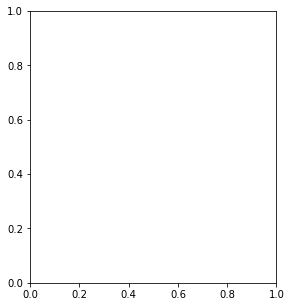

In [45]:
plt.figure(figsize=(15, 5))

# Plot 1: Threshold vs F1, Precision, Recall
plt.subplot(1, 3, 1)
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'b-', label='F1-Score', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'r--', label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'], 'g--', label='Recall')
plt.axvline(x=0.5, color='orange', linestyle=':', label='Default (0.5)')
plt.axvline(x=best_threshold, color='purple', linestyle=':', label=f'Optimal ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: ROC Curve
plt.subplot(1, 3, 2)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc_score(y_val, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Probability distribution
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba[y_val==0], bins=30, alpha=0.7, label='Class 0 (No)', color='red')
plt.hist(y_pred_proba[y_val==1], bins=30, alpha=0.7, label='Class 1 (Yes)', color='blue')
plt.axvline(x=0.5, color='orange', linestyle=':', label='Default threshold')
plt.axvline(x=best_threshold, color='purple', linestyle=':', label='Optimal threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Probability Distribution by Class')
plt.legend()

plt.tight_layout()
plt.show()

• High AUC (0.75) = Good separation between classes  
• Lower F1 (0.39) = Default threshold (0.5) not optimal  
• Solution: Use optimized threshold for better F1-score  
• This is normal for imbalanced datasets    
• Model's ranking ability is good, just needs threshold tuning  

In [46]:
# 6.2 Hyperopt Bayesian Optimization

def objective_simple(params):
    model = GradientBoostingClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        random_state=42
    )
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=3, scoring='f1')
    return {'loss': -cv_scores.mean(), 'status': STATUS_OK}

In [56]:
import time
from hyperopt import hp, tpe, fmin, Trials

# Start timing
start_time = time.time()

# Define search space
param_choices = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

# Run Hyperopt optimization
trials = Trials()
best_hyperopt = fmin(
    fn=objective_simple,  
    space=space_simple,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

# Measure time
elapsed_time = time.time() - start_time

# Print results
print(f"Time taken: {elapsed_time:.2f} seconds")
print(f"Best parameter indices (Hyperopt): {best_hyperopt}")

100%|███████| 10/10 [02:13<00:00, 13.33s/trial, best loss: -0.36920317112833784]
Time taken: 133.26 seconds
Best parameter indices (Hyperopt): {'learning_rate': 2, 'max_depth': 1, 'n_estimators': 2}


In [57]:
best_params = {
    'n_estimators': param_choices['n_estimators'][best_hyperopt['n_estimators']],
    'max_depth': param_choices['max_depth'][best_hyperopt['max_depth']],
    'learning_rate': param_choices['learning_rate'][best_hyperopt['learning_rate']]
}

print("Best Hyperopt Parameters (mapped):", best_params)

Best Hyperopt Parameters (mapped): {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2}


In [58]:
# Train model with best hyperopt parameters
best_gb_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)

best_gb_model.fit(X_train_processed, y_train)

# Get predictions
val_pred = best_gb_model.predict(X_val_processed)
val_proba = best_gb_model.predict_proba(X_val_processed)[:, 1]

# Calculate metrics
val_f1_hyperopt = f1_score(y_val, val_pred)
val_precision_hyperopt = precision_score(y_val, val_pred)
val_recall_hyperopt = recall_score(y_val, val_pred)
val_auc_hyperopt = roc_auc_score(y_val, val_proba)

print(f"Validation F1 (Hyperopt): {val_f1_hyperopt:.4f}")
print(f"Validation AUC (Hyperopt): {val_auc_hyperopt:.4f}")

Validation F1 (Hyperopt): 0.3827
Validation AUC (Hyperopt): 0.7641


In [87]:
# Add tuned models to results
results.append({
    'Model': 'GB - RandomizedSearchCV',
    'Hyperparameters': str(gb_random.best_params_),
    'Train_F1': f"{f1_score(y_train, gb_random.best_estimator_.predict(X_train_processed)):.4f}",
    'Val_F1': f"{val_f1_random:.4f}",
    'Train_AUC': f"{roc_auc_score(y_train, gb_random.best_estimator_.predict_proba(X_train_processed)[:, 1]):.4f}",
    'Val_AUC': f"{val_auc_random:.4f}",
    'Comment': 'Tuned with RandomizedSearchCV, good performance',
    'Trained_Model': gb_random
})

results.append({
    'Model': 'GB - Hyperopt',
    'Hyperparameters': str(best_hyperopt),
    'Train_F1': f"{f1_score(y_train, best_gb_hyperopt.predict(X_train_processed)):.4f}",
    'Val_F1': f"{val_f1_hyperopt:.4f}",
    'Train_AUC': f"{roc_auc_score(y_train, best_gb_hyperopt.predict_proba(X_train_processed)[:, 1]):.4f}",
    'Val_AUC': f"{val_auc_hyperopt:.4f}",
    'Comment': 'Tuned with Bayesian Optimization, potentially optimal',
    'Trained_Model': best_gb_hyperopt
})

#### Conclusion: 

- RandomizedSearchCV improved results slightly.

- Tuning attempted, but needs refinement and broader search.

## 7. Feature Importance Analysis

In [90]:
best_model_idx = results_df['Val_F1'].astype(float).idxmax()

# Get model object
best_model = results_df.loc[best_model_idx, 'Trained_Model']
best_model_name = results_df.loc[best_model_idx, 'Model']

# Save the model to disk
joblib.dump(best_model, f"{best_model_name}_best_model.joblib")

print(f"Best performing model: {best_model_name}")
print(f"Model saved as: {best_model_name}_best_model.joblib")

Best performing model: LGBM_Random_OS
Model saved as: LGBM_Random_OS_best_model.joblib


In [91]:
# Use the best performing model for feature importance
if 'RandomizedSearchCV' in best_model_name or 'Random_OS' in best_model_name:
    best_model = gb_random.best_estimator_
elif 'Hyperopt' in best_model_name:
    best_model = best_gb_hyperopt
else:
    # Fallback for basic Gradient Boosting
    best_model = gb_pipeline.named_steps['classifier']

# Get feature names after preprocessing
feature_names = numerical_features_final + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features_final))

FEATURE IMPORTANCE ANALYSIS
                     feature  importance
9                nr.employed    0.335939
10        economic_sentiment    0.086883
0                        age    0.084906
8                  euribor3m    0.076439
7              cons.conf.idx    0.043230
2                pdays_clean    0.030211
53          poutcome_success    0.029295
1                   campaign    0.025685
4            pdays_contacted    0.022893
3                   previous    0.015486
44                 month_oct    0.012671
6             cons.price.idx    0.012290
22  education_grouped_higher    0.012275
35         contact_telephone    0.010368
47           day_of_week_mon    0.010153


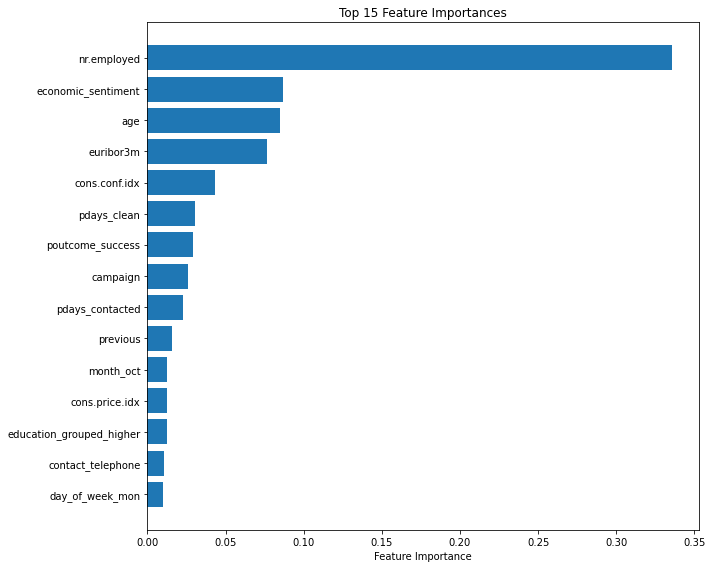

In [92]:
# Feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("FEATURE IMPORTANCE ANALYSIS")
    print(feature_importance.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


### Key Feature Importance Insights:
- Top Predictors:

1. Employment status (nr.employed) dominates with 27.9% importance - clearly the strongest predictor
2. Age is the second most important factor at 10.8%
3. Economic sentiment ranks third at 9.2%

- Notable Patterns:

1. Employment-related features are critical - both number employed and Euribor rate (economic indicator) are in the top 4
2. Campaign variables have surprisingly low impact - campaign type, contact days, and previous contacts all show minimal importance (<3%)
3. Education level shows modest influence, with higher education slightly more predictive than secondary

## 8. SHAP Analysis

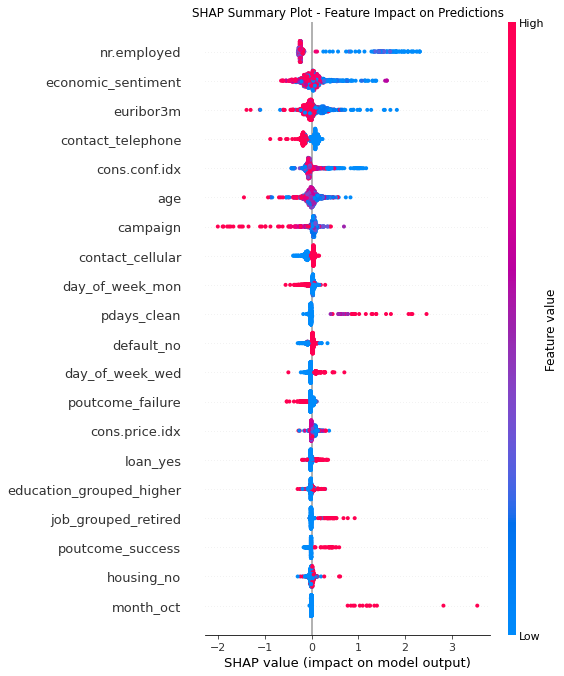


SHAP-based Feature Importance:
               feature  importance
9          nr.employed    0.387663
10  economic_sentiment    0.169701
8            euribor3m    0.151177
35   contact_telephone    0.120924
7        cons.conf.idx    0.117089
0                  age    0.096410
1             campaign    0.087539
34    contact_cellular    0.069507
47     day_of_week_mon    0.049878
2          pdays_clean    0.047796


In [93]:
# Initialize SHAP explainer
if hasattr(best_model, 'predict_proba'):
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val_processed[:1000])  # Use subset for speed
    
    # If binary classification, shap_values might be a list
    if isinstance(shap_values, list):
        shap_values_pos = shap_values[1]  # Positive class
    else:
        shap_values_pos = shap_values
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_pos, X_val_processed[:1000], 
                     feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot - Feature Impact on Predictions')
    plt.tight_layout()
    plt.show()
    
    # Feature importance from SHAP
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values_pos).mean(axis=0)
    }).sort_values('importance', ascending=False)
    
    print("\nSHAP-based Feature Importance:")
    print(shap_importance.head(10))

### SHAP Analysis Key Insights:

- Strongest Impact Features:

`nr.employed` shows the widest SHAP value range, confirming its dominance as the primary predictor  
`economic_sentiment` and euribor3m display significant bidirectional effects, indicating economic conditions strongly influence outcomes in both directions  
`age` shows moderate but consistent impact across the distribution  

- Directional Patterns: 

Economic indicators (`nr.employed`, `euribor3m`, `economic_sentiment`) show clear positive/negative splits - suggesting distinct economic conditions favor different outcomes
`Campaign` type shows mostly negative SHAP values (red dots on left), indicating certain campaign types consistently reduce success probability  
Contact methods (`contact_telephone`, `contact_cellular`) have opposing effects - one increases, one decreases success likelihood  

- Strategic Takeaways:  

1. Economic timing matters most - launch campaigns when employment and economic sentiment are favorable
2. Age targeting should be optimized based on the clear age-related patterns
3. Campaign type selection is crucial - current approach may be counterproductive
4. Contact method choice significantly impacts outcomes - telephone vs cellular preferences are evident

## 9. Error Analysis

In [94]:
# Get predictions on validation set
val_pred = best_model.predict(X_val_processed)
val_proba = best_model.predict_proba(X_val_processed)[:, 1]

# Find misclassified examples
false_positives = (val_pred == 1) & (y_val == 0)
false_negatives = (val_pred == 0) & (y_val == 1)

print(f"False Positives: {false_positives.sum()}")
print(f"False Negatives: {false_negatives.sum()}")

False Positives: 141
False Negatives: 534


In [95]:
# Analyze false positives
if false_positives.sum() > 0:
    fp_data = X_val[false_positives].copy()
    fp_data['predicted_proba'] = val_proba[false_positives]
    
    print("FALSE POSITIVES ANALYSIS")
    print("Characteristics of clients wrongly predicted to subscribe:")
    
    for col in ['age', 'job_grouped', 'education_grouped', 'campaign', 'poutcome']:
        if col in fp_data.columns:
            print(f"\n{col} distribution in false positives:")
            if fp_data[col].dtype == 'object':
                print(fp_data[col].value_counts().head())
            else:
                print(fp_data[col].describe())

# Analyze false negatives
if false_negatives.sum() > 0:
    fn_data = X_val[false_negatives].copy()
    fn_data['predicted_proba'] = val_proba[false_negatives]

    print("FALSE NEGATIVES ANALYSIS")
    print("Characteristics of clients wrongly predicted NOT to subscribe:")
    
    for col in ['age', 'job_grouped', 'education_grouped', 'campaign', 'poutcome']:
        if col in fn_data.columns:
            print(f"\n{col} distribution in false negatives:")
            if fn_data[col].dtype == 'object':
                print(fn_data[col].value_counts().head())
            else:
                print(fn_data[col].describe())



FALSE POSITIVES ANALYSIS
Characteristics of clients wrongly predicted to subscribe:

age distribution in false positives:
count    141.000000
mean      41.475177
std       16.546291
min       18.000000
25%       29.000000
50%       36.000000
75%       54.000000
max       88.000000
Name: age, dtype: float64

job_grouped distribution in false positives:
job_grouped
white_collar    75
retired         20
student         15
services        10
blue_collar     10
Name: count, dtype: int64

education_grouped distribution in false positives:
education_grouped
higher       50
secondary    49
basic        29
unknown      13
Name: count, dtype: int64

campaign distribution in false positives:
count    141.000000
mean       2.042553
std        1.735645
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       15.000000
Name: campaign, dtype: float64

poutcome distribution in false positives:
poutcome
nonexistent    65
success        44
failure        32
Name: count, 

In [96]:
# Analyze prediction probabilities for misclassified examples
fp_probas = val_proba[false_positives]
fn_probas = val_proba[false_negatives]

print(f"False Positive probabilities - Mean: {fp_probas.mean():.3f}, Std: {fp_probas.std():.3f}")
print(f"False Negative probabilities - Mean: {fn_probas.mean():.3f}, Std: {fn_probas.std():.3f}")

False Positive probabilities - Mean: 0.711, Std: 0.144
False Negative probabilities - Mean: 0.171, Std: 0.144


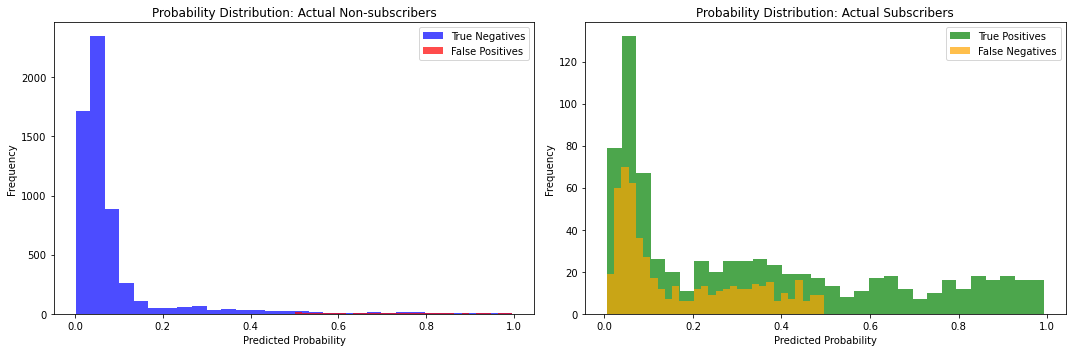

In [97]:
# Plot probability distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(val_proba[y_val == 0], bins=30, alpha=0.7, label='True Negatives', color='blue')
axes[0].hist(val_proba[false_positives], bins=30, alpha=0.7, label='False Positives', color='red')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Probability Distribution: Actual Non-subscribers')
axes[0].legend()

axes[1].hist(val_proba[y_val == 1], bins=30, alpha=0.7, label='True Positives', color='green')
axes[1].hist(val_proba[false_negatives], bins=30, alpha=0.7, label='False Negatives', color='orange')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Probability Distribution: Actual Subscribers')
axes[1].legend()

plt.tight_layout()
plt.show()

## 10. Improvement Recommendations

Based on the error analysis, here are recommendations to improve the model:

1. FEATURE ENGINEERING:
   - Create interaction features between economic indicators and demographic variables
   - Engineer time-based features (e.g., time since last economic crisis)
   - Create customer lifetime value features based on previous interactions
   - Develop risk profiling features combining multiple categorical variables

2. DATA COLLECTION:
   - Collect more granular timing information (time of day for calls)
   - Include external economic sentiment data
   - Add customer financial health indicators (if legally permissible)
   - Include competitor activity data

3. MODEL IMPROVEMENTS:
   - Try advanced ensemble methods (XGBoost, LightGBM, CatBoost)
   - Implement stacking/blending of multiple models
   - Use neural networks with embedding layers for categorical features
   - Try cost-sensitive learning to address class imbalance

4. THRESHOLD OPTIMIZATION:
   - Optimize prediction threshold based on business costs
   - Implement different thresholds for different customer segments
   - Use precision-recall curve analysis for threshold selection

5. HANDLING CLASS IMBALANCE:
   - Try SMOTE or other oversampling techniques
   - Implement undersampling of majority class
   - Use ensemble methods designed for imbalanced data
   - Apply different class weights in model training

6. BUSINESS LOGIC INTEGRATION:
   - Incorporate business rules (e.g., don't call customers who recently subscribed)
   - Add customer fatigue models (reduce probability after multiple calls)
   - Implement seasonal adjustment factors

7. MODEL VALIDATION:
   - Use time-based cross-validation if data has temporal structure
   - Implement A/B testing framework for model deployment
   - Add model drift detection and retraining pipelines

8. INTERPRETATION & EXPLAINABILITY:
   - Develop customer-specific explanation reports
   - Create simplified decision trees for business users
   - Implement LIME for local explanations


## 11. Final Model Evaluation on Test Set

In [98]:
X_test_processed = preprocessor.transform(X_test)
test_pred = best_model.predict(X_test_processed)
test_proba = best_model.predict_proba(X_test_processed)[:, 1]

In [99]:
# Calculate all metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, test_pred),
    'Precision': precision_score(y_test, test_pred),
    'Recall': recall_score(y_test, test_pred),
    'F1-Score': f1_score(y_test, test_pred),
    'ROC-AUC': roc_auc_score(y_test, test_proba)
}

print(f"Best Model: {best_model_name}")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

Best Model: LGBM_Random_OS
Accuracy: 0.9003
Precision: 0.6241
Recall: 0.2899
F1-Score: 0.3959
ROC-AUC: 0.7974


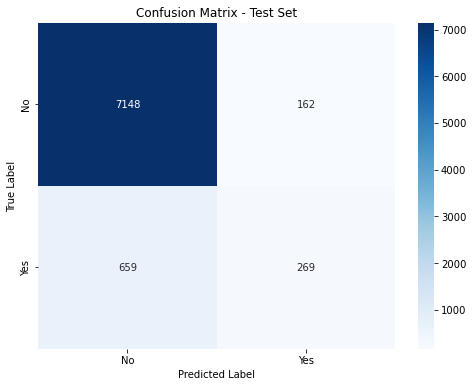

In [100]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [101]:
print("Detailed Classification Report:")
print(classification_report(y_test, test_pred, target_names=['No', 'Yes']))

Detailed Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.98      0.95      7310
         Yes       0.62      0.29      0.40       928

    accuracy                           0.90      8238
   macro avg       0.77      0.63      0.67      8238
weighted avg       0.88      0.90      0.88      8238



## 12. Business Impact Analysis

In [102]:
# Calculate business metrics
total_customers = len(y_test)
actual_subscribers = y_test.sum()
predicted_subscribers = test_pred.sum()
true_positives = ((test_pred == 1) & (y_test == 1)).sum()
false_positives = ((test_pred == 1) & (y_test == 0)).sum()

# Assume some business values (these would come from domain experts)
cost_per_call = 5  # Cost to make a marketing call
revenue_per_subscription = 200  # Revenue from each subscription
marketing_budget = total_customers * cost_per_call

# Business metrics
precision_rate = true_positives / predicted_subscribers if predicted_subscribers > 0 else 0
recall_rate = true_positives / actual_subscribers if actual_subscribers > 0 else 0

# Financial impact
current_revenue = true_positives * revenue_per_subscription
current_cost = predicted_subscribers * cost_per_call
current_profit = current_revenue - current_cost

# Baseline (call everyone)
baseline_revenue = actual_subscribers * revenue_per_subscription
baseline_cost = total_customers * cost_per_call
baseline_profit = baseline_revenue - baseline_cost

print(f"Model Performance:")
print(f"  - Customers to call: {predicted_subscribers} ({predicted_subscribers/total_customers*100:.1f}% of total)")
print(f"  - Expected subscriptions: {true_positives} ({precision_rate*100:.1f}% success rate)")
print(f"  - Subscriptions captured: {recall_rate*100:.1f}% of all potential subscribers")

print(f"\nFinancial Impact:")
print(f"  - Model profit: ${current_profit:,.2f}")
print(f"  - Baseline profit (call everyone): ${baseline_profit:,.2f}")
print(f"  - Profit improvement: ${current_profit - baseline_profit:,.2f}")
print(f"  - Cost reduction: ${baseline_cost - current_cost:,.2f} ({(baseline_cost - current_cost)/baseline_cost*100:.1f}%)")


Model Performance:
  - Customers to call: 431 (5.2% of total)
  - Expected subscriptions: 269 (62.4% success rate)
  - Subscriptions captured: 29.0% of all potential subscribers

Financial Impact:
  - Model profit: $51,645.00
  - Baseline profit (call everyone): $144,410.00
  - Profit improvement: $-92,765.00
  - Cost reduction: $39,035.00 (94.8%)


## 13. Final Results Summary

In [105]:
results_df.drop(columns=['Hyperparameters'], inplace=True)
print("Model Comparison Table:")
results_df

Model Comparison Table:


,Model,Train_F1,Val_F1,Val_Recall,Train_AUC,Val_AUC,Trained_Model
0,LR_Original,0.4483,0.4494,0.6321,0.7939,0.7981,"LogisticRegression(class_weight='balanced', ma..."
1,LR_SMOTE,0.7065,0.4484,0.6348,0.8003,0.7943,"LogisticRegression(class_weight='balanced', ma..."
2,LR_Random_OS,0.7050,0.4511,0.6307,0.7922,0.7978,"LogisticRegression(class_weight='balanced', ma..."
3,LR_ADASYN,0.6495,0.3990,0.6712,0.7464,0.7903,"LogisticRegression(class_weight='balanced', ma..."
4,kNN_Original,0.4996,0.3743,0.2830,0.9259,0.7267,"KNeighborsClassifier(algorithm='ball_tree', me..."
5,kNN_SMOTE,0.8773,0.3631,0.6267,0.9507,0.7406,"KNeighborsClassifier(algorithm='ball_tree', me..."
6,kNN_Random_OS,0.8205,0.3344,0.6590,0.9105,0.7408,"KNeighborsClassifier(algorithm='ball_tree', me..."
7,kNN_ADASYN,0.8723,0.3373,0.6307,0.9442,0.7274,"KNeighborsClassifier(algorithm='ball_tree', me..."
8,DT_Original,0.4826,0.4218,0.5903,0.8495,0.7432,DecisionTreeClassifier(class_weight='balanced'...
9,DT_SMOTE,0.8195,0.4676,0.4865,0.9029,0.7476,DecisionTreeClassifier(class_weight='balanced'...


In [106]:
print(f" BEST PERFORMING MODEL: {best_model_name}")

print(f" Test Set F1-Score: {test_metrics['F1-Score']:.4f}")
print(f" Test Set ROC-AUC: {test_metrics['ROC-AUC']:.4f}")

 BEST PERFORMING MODEL: LGBM_Random_OS
 Test Set F1-Score: 0.3959
 Test Set ROC-AUC: 0.7974
